In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import random

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import pyarrow as pa
import pyarrow.parquet as pq

import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, spearmanr , shapiro


In [3]:
CFG = {
    'BATCH_SIZE': 4096,
    'EPOCHS': 10,
    'LEARNING_RATE': 1e-3,
    'SEED' : 42
}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [6]:
train= pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/CRT/train_part1.parquet' , engine= 'pyarrow')

In [7]:
import plotly.express as px

train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

In [8]:
def summary(df):
    sum = pd.DataFrame(train.dtypes, columns=['dtypes'])
    sum['결측치 개수'] = df.isna().sum()
    sum['결측치 비율'] = (df.isna().sum())/len(df)
    sum['고유값 개수'] = df.nunique().values
    sum['데이터 개수'] = df.count().values


    return sum

summary(train).style.background_gradient(cmap='Blues')

In [9]:
corr = train.corr(numeric_only= True)

corr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr.style.background_gradient(cmap='Blues')

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


feature 분석

(A) 범주형(임베딩용)

- user/context: gender, age_group, day_of_week, hour

- item: inventory_id

- sequence: seq (쉼표로 구분된 과거 inventory_id 시퀀스)

<br>


(B) 연속형(스케일링/버킷화)

- l_feat_1 ~ l_feat_27 : 로그 기반/랭크류처럼 보이는 long-term 통계 → 표준화(μ,σ) 또는 분위수 변환 권장

- feat_e_1 ~ feat_e_10, feat_d_1 ~ feat_d_6, feat_c_1 ~ feat_c_8, feat_b_1 ~ feat_b_6,
feat_a_1 ~ feat_a_18 : 아이템/유저/컨텍스트 파생 수치 → 표준화 또는 버킷화(DeepFM 필드로 쓸 거면 버킷)

- history_a_1 ~ history_a_7, history_b_1 ~ history_b_30 : 시퀀스 통계 요약(정규화된 비율/가중치처럼 보임) → 그대로 연속형으로 사용(스케일만 맞춤)



In [10]:
train.head(5)

gender  age_group  inventory_id  day_of_week  hour  \
0     1.0        7.0          36.0          5.0  13.0   
1     1.0        7.0           2.0          5.0   8.0   
2     1.0        7.0          36.0          5.0  11.0   
3     1.0        8.0          37.0          5.0  11.0   
4     2.0        7.0          37.0          5.0   7.0   

                                                 seq  l_feat_1  l_feat_2  \
0  9,18,269,516,57,97,527,74,317,311,269,479,57,7...       1.0       2.0   
1  9,144,269,57,516,97,527,74,315,317,311,269,479...       2.0       2.0   
2  269,516,57,97,165,527,74,77,317,269,75,450,15,...       1.0       2.0   
3  269,57,516,21,214,269,561,214,269,561,247,516,...       2.0       2.0   
4  144,269,57,516,35,479,57,516,527,74,77,318,193...       2.0       2.0   

   l_feat_3  l_feat_4  ...  history_b_22  history_b_23  history_b_24  \
0       1.0      23.0  ...      0.070092      0.070092      0.011682   
1       3.0      17.0  ...      0.072990      0.072990      0.012165   
2       1.0       7.0  ...      0.057177      0.057177      0.009530   
3       2.0       7.0  ...      0.100449      0.100449      0.016741   
4       3.0      24.0  ...      0.064512      0.064512      0.010752   

   history_b_25  history_b_26  history_b_27  history_b_28  history_b_29  \
0      0.004673      0.087226      0.049843      0.015576      0.040498   
1      0.004866      0.045416      0.051904      0.016220      0.042172   
2      0.003812      0.035577      0.081318      0.012706      0.033036   
3      0.006697      0.062502      0.071430      0.022322      0.058037   
4      0.004301      0.040141      0.045875      0.014336      0.037274   

   history_b_30  clicked  
0      0.051401        0  
1      0.026763        0  
2      0.062898        0  
3      0.073659        0  
4      0.023654        0  

[5 rows x 119 columns]

In [11]:
df = train.copy()

In [12]:
import re
import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---------------------------------------
# 0) 유틸
# ---------------------------------------
def tight(axs):
    plt.tight_layout()
    for ax in np.ravel(axs):
        if hasattr(ax, "grid"):
            ax.grid(True, alpha=0.15)

def top_k(series, k=20):
    vc = series.value_counts(dropna=False)
    return vc.iloc[:k]

def is_numeric(s):
    return pd.api.types.is_numeric_dtype(s)

def cols_like(df, prefix):
    return [c for c in df.columns if c.startswith(prefix)]

def cols_regex(df, pattern):
    pat = re.compile(pattern)
    return [c for c in df.columns if pat.search(c)]

# ---------------------------------------
# 1) 컬럼 그룹 자동 인식
# ---------------------------------------
def infer_column_groups(df, target_col="clicked"):
    groups = {}
    groups["target"] = [target_col] if target_col in df.columns else []
    groups["categorical"] = [c for c in ["gender","age_group","day_of_week","hour","inventory_id"] if c in df.columns]
    # 연속형 패턴군
    for p in ["feat_e_", "feat_d_", "feat_c_", "feat_b_", "feat_a_"]:
        cand = cols_like(df, p)
        if cand:
            groups[p[:-1]] = cand  # 'feat_e', 'feat_d' 등으로 저장
    # 히스토리/시퀀스
    groups["seq"] = ["seq"] if "seq" in df.columns else []
    groups["history_a"] = cols_like(df, "history_a_")
    groups["history_b"] = cols_like(df, "history_b_")
    # 나머지 숫자형에서 이미 분류된 것 제외
    used = set(sum(groups.values(), []))
    numeric_rest = [c for c in df.columns if c not in used and is_numeric(df[c])]
    if numeric_rest:
        groups["numeric_others"] = numeric_rest
    return groups

# ---------------------------------------
# 2) 범주형: 분포 + CTR
# ---------------------------------------
def plot_categorical_overview(df, cat_cols, target="clicked", topk=20, ncols=3, figsize=(14, 4)):
    if not cat_cols:
        return
    n = len(cat_cols)
    nrows = math.ceil(n / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows))
    axs = np.array(axs).reshape(nrows, ncols)
    for i, col in enumerate(cat_cols):
        ax = axs[i // ncols, i % ncols]
        vc_top = top_k(df[col], topk)
        x = vc_top.index.astype(str)
        ax.bar(x, vc_top.values)
        ax.set_title(f"[Count] {col}")
        ax.set_xticklabels(x, rotation=45, ha="right")
    tight(axs)
    plt.show()

    # CTR 막대
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows))
    axs = np.array(axs).reshape(nrows, ncols)
    for i, col in enumerate(cat_cols):
        ax = axs[i // ncols, i % ncols]
        tmp = df[[col, target]].copy()
        # 상위 topk 빈도 기준으로 제한
        top_idx = set(top_k(tmp[col], topk).index.tolist())
        tmp = tmp[tmp[col].isin(top_idx)]
        ctr = tmp.groupby(col)[target].mean().sort_values(ascending=False)
        ax.bar(ctr.index.astype(str), ctr.values)
        ax.set_title(f"[CTR] {col}")
        ax.set_xticklabels(ctr.index.astype(str), rotation=45, ha="right")
    tight(axs)
    plt.show()

# ---------------------------------------
# 3) 연속형: 분포 + 타겟별 분포 비교
# ---------------------------------------
def plot_numeric_distribution(df, num_cols, bins=50, ncols=3, figsize=(14, 4)):
    if not num_cols:
        return
    n = len(num_cols)
    nrows = math.ceil(n / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows))
    axs = np.array(axs).reshape(nrows, ncols)
    for i, col in enumerate(num_cols):
        ax = axs[i // ncols, i % ncols]
        s = pd.to_numeric(df[col], errors="coerce").dropna()
        ax.hist(s, bins=bins)
        ax.set_title(f"[Hist] {col}")
    tight(axs)
    plt.show()

def plot_numeric_by_target(df, num_cols, target="clicked", bins=70, ncols=3, figsize=(14, 4)):
    if not num_cols or target not in df.columns:
        return
    clicked_vals = df[target].dropna().unique()
    if len(clicked_vals) < 2:
        return
    n = len(num_cols)
    nrows = math.ceil(n / ncols)
    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows))
    axs = np.array(axs).reshape(nrows, ncols)
    for i, col in enumerate(num_cols):
        ax = axs[i // ncols, i % ncols]
        a = pd.to_numeric(df.loc[df[target]==0, col], errors="coerce").dropna()
        b = pd.to_numeric(df.loc[df[target]==1, col], errors="coerce").dropna()
        ax.hist(a, bins=bins, alpha=0.6, label="0")
        ax.hist(b, bins=bins, alpha=0.6, label="1")
        ax.set_title(f"[Hist by {target}] {col}")
        ax.legend()
    tight(axs)
    plt.show()

# ---------------------------------------
# 4) 상관 히트맵 (간단 구현)
# ---------------------------------------
def plot_corr_heatmap(df, cols, vmax=1.0, figsize=(10, 8)):
    if not cols:
        return
    num_df = df[cols].apply(pd.to_numeric, errors="coerce")
    corr = num_df.corr()
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(corr.values, vmin=-vmax, vmax=vmax)
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=90)
    ax.set_yticklabels(cols)
    fig.colorbar(im, ax=ax, fraction=0.03)
    ax.set_title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 5) PCA 2D 스캐터
# ---------------------------------------
def plot_pca_scatter(df, cols, target="clicked", scale=True, figsize=(7, 6)):
    if not cols:
        return
    X = df[cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
    if scale:
        X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    fig, ax = plt.subplots(figsize=figsize)
    if target in df.columns:
        y = df[target].fillna(0).astype(int).values
        for cls in np.unique(y):
            m = y == cls
            ax.scatter(X2[m, 0], X2[m, 1], s=8, label=f"{target}={cls}", alpha=0.7)
        ax.legend()
    else:
        ax.scatter(X2[:, 0], X2[:, 1], s=8, alpha=0.7)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA Scatter")
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 6) 시퀀스/히스토리 피처
#    - seq: 'a,b,c' 같은 문자열을 리스트로 변환 후 길이/토큰빈도 시각화
#    - history_*: 연속형으로 간주하고 분포/타겟별 비교 가능
# ---------------------------------------
def parse_seq_column(series):
    # "1,2,3" 형태 → [1,2,3] 변환, 공백 제거
    out = []
    for v in series.fillna(""):
        if isinstance(v, list):
            out.append(v)
        else:
            s = str(v).strip()
            if not s:
                out.append([])
            else:
                tokens = [t.strip() for t in s.split(",") if t.strip() != ""]
                out.append(tokens)
    return out

def plot_seq_length_and_top_tokens(df, seq_col="seq", topk=30, figsize=(12,4)):
    if seq_col not in df.columns:
        return
    seqs = parse_seq_column(df[seq_col])
    lengths = [len(s) for s in seqs]
    # 길이 분포
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].hist(lengths, bins=40)
    axs[0].set_title(f"[seq length] {seq_col}")
    axs[0].grid(True, alpha=0.2)
    # 토큰 빈도
    tokens = [tok for s in seqs for tok in s]
    cnt = Counter(tokens)
    most = cnt.most_common(topk)
    if most:
        labels, vals = zip(*most)
        axs[1].bar(range(len(labels)), vals)
        axs[1].set_xticks(range(len(labels)))
        axs[1].set_xticklabels(labels, rotation=90)
        axs[1].set_title(f"[seq token freq Top{topk}] {seq_col}")
        axs[1].grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()



/tmp/ipython-input-350534676.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, ha="right")
/tmp/ipython-input-350534676.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, ha="right")
/tmp/ipython-input-350534676.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, ha="right")
/tmp/ipython-input-350534676.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=45, ha="right")
/tmp/ipython-input-350534676.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

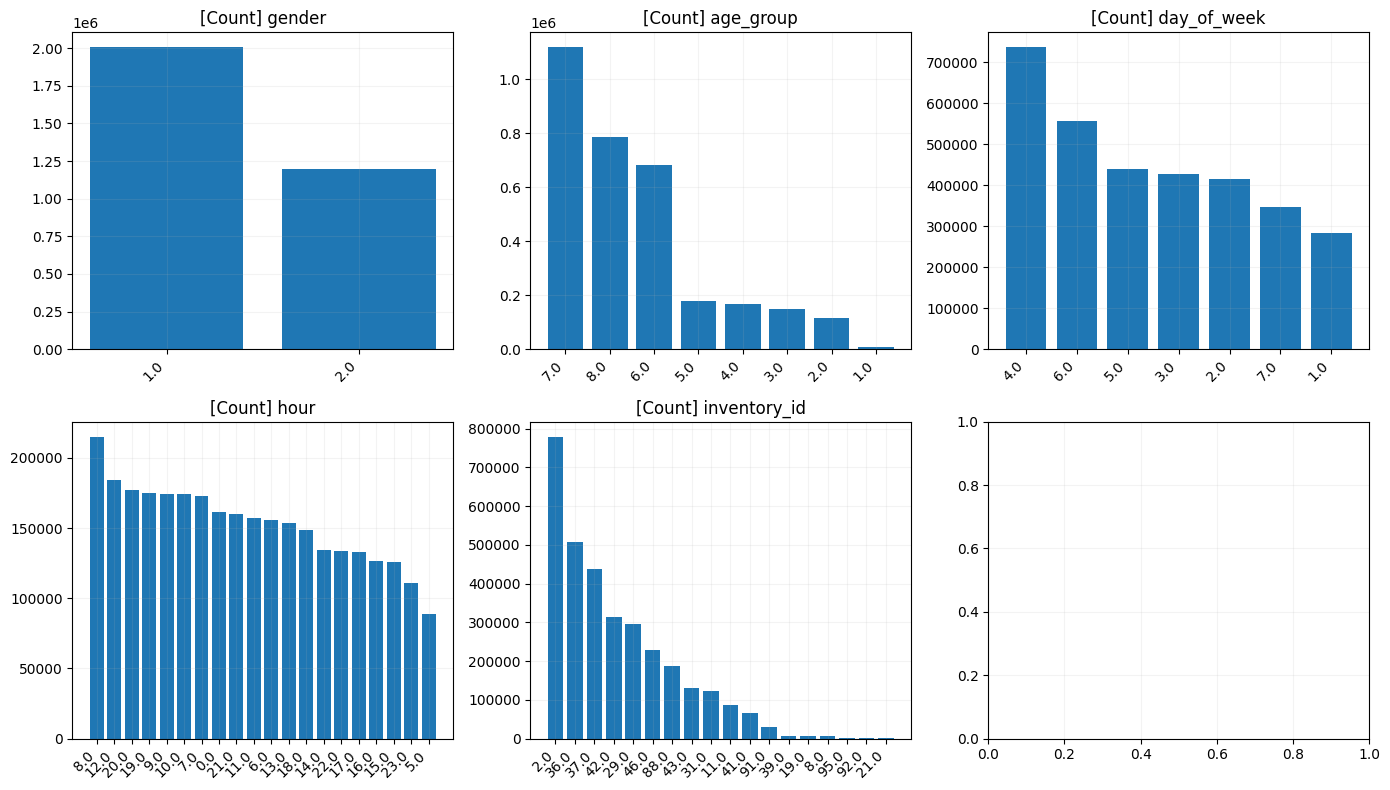

/tmp/ipython-input-350534676.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ctr.index.astype(str), rotation=45, ha="right")
/tmp/ipython-input-350534676.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ctr.index.astype(str), rotation=45, ha="right")
/tmp/ipython-input-350534676.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ctr.index.astype(str), rotation=45, ha="right")
/tmp/ipython-input-350534676.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ctr.index.astype(str), rotation=45, ha="right")
/tmp/ipython-input-350534676.py:89: UserWarning: set_ticklabels() sh

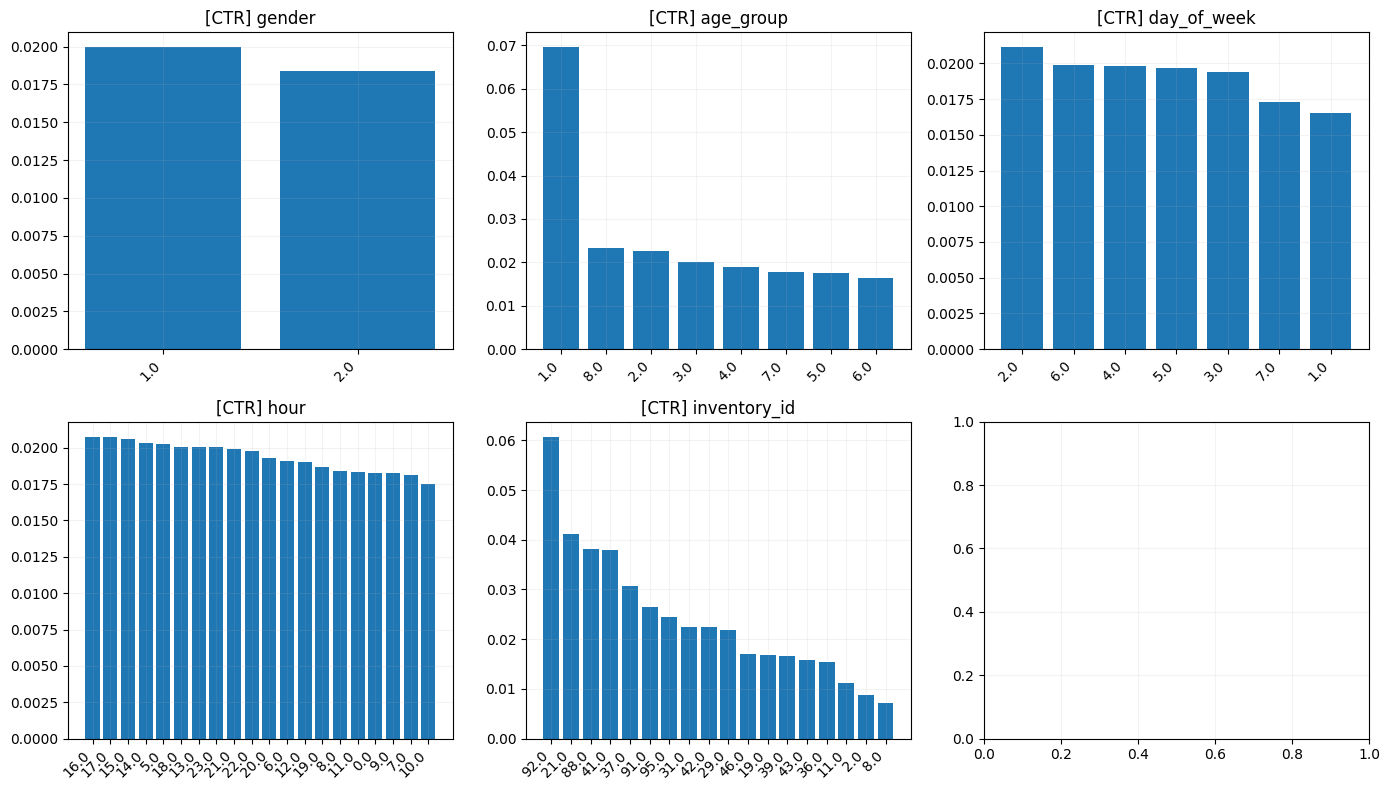

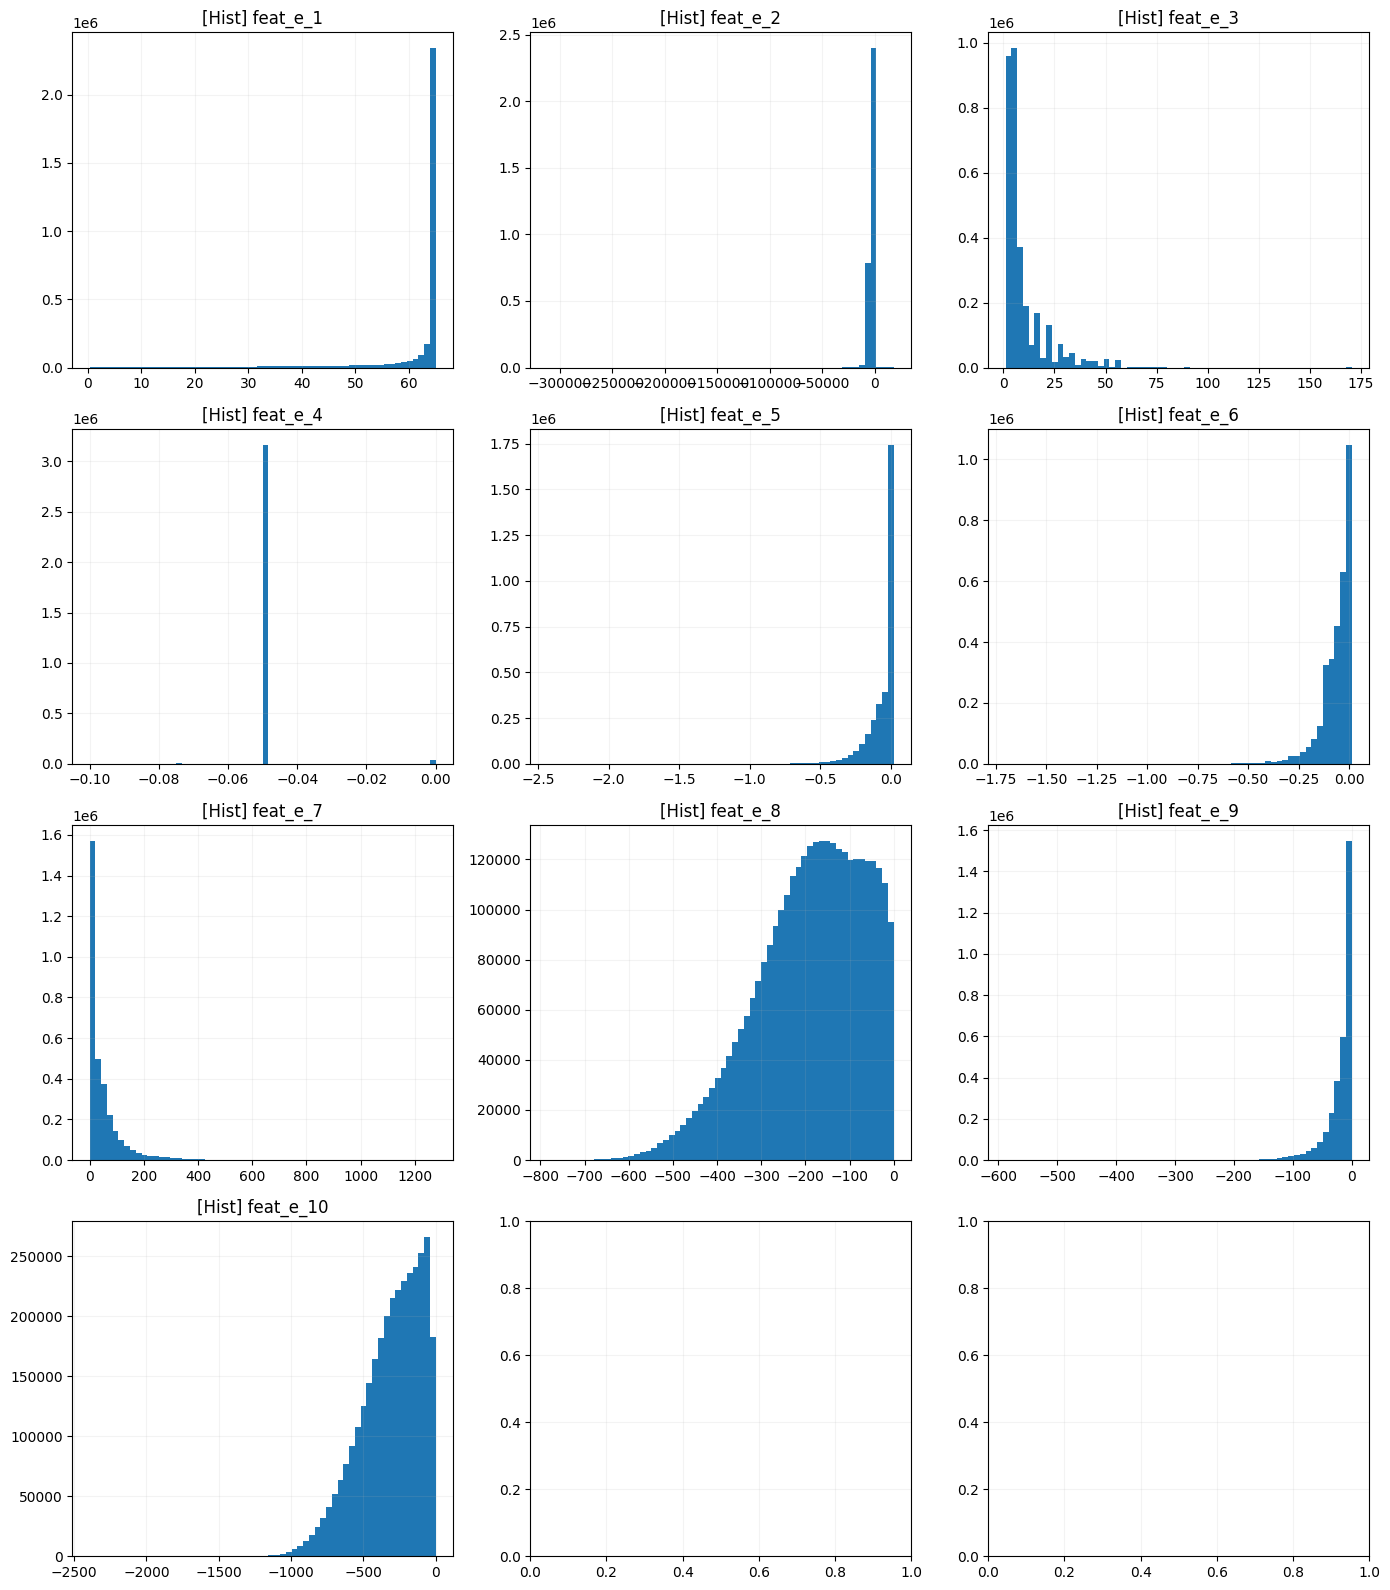

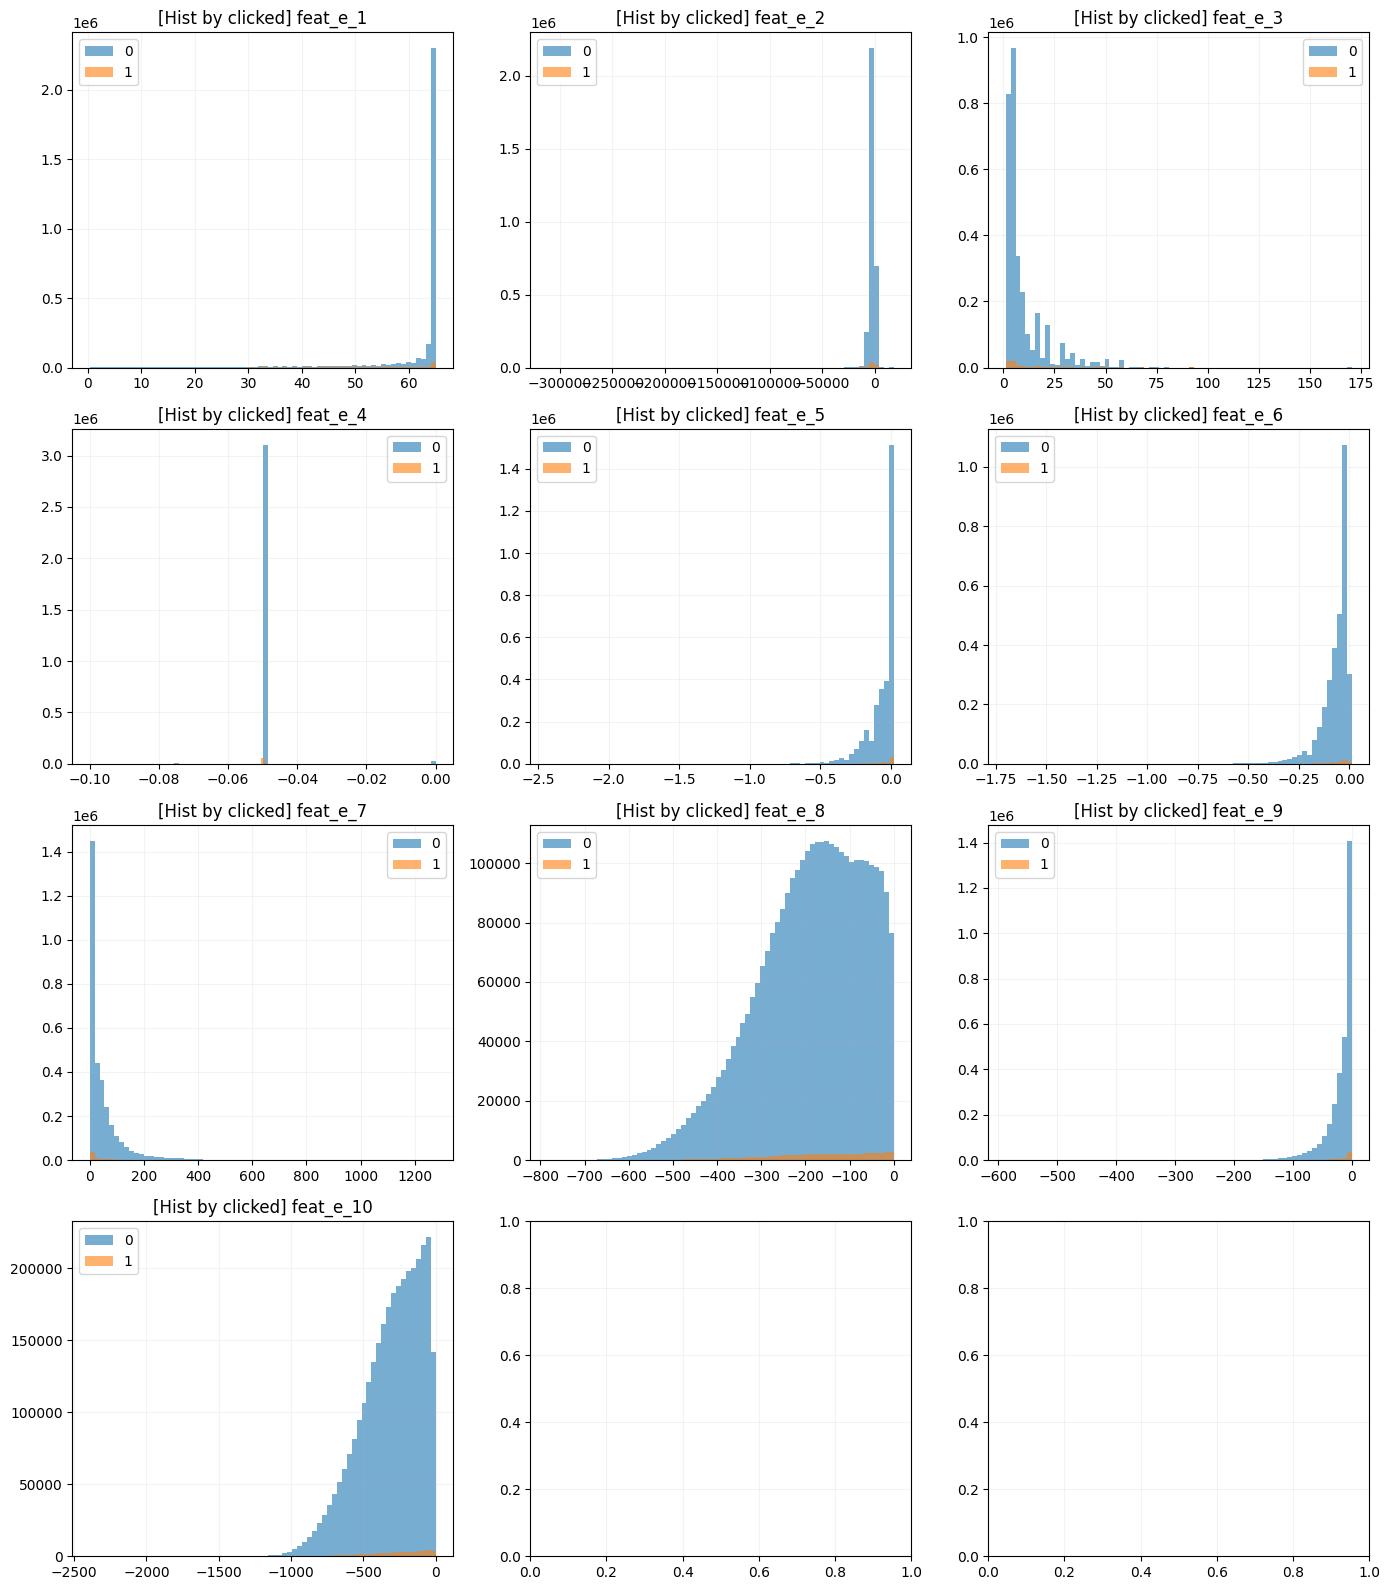

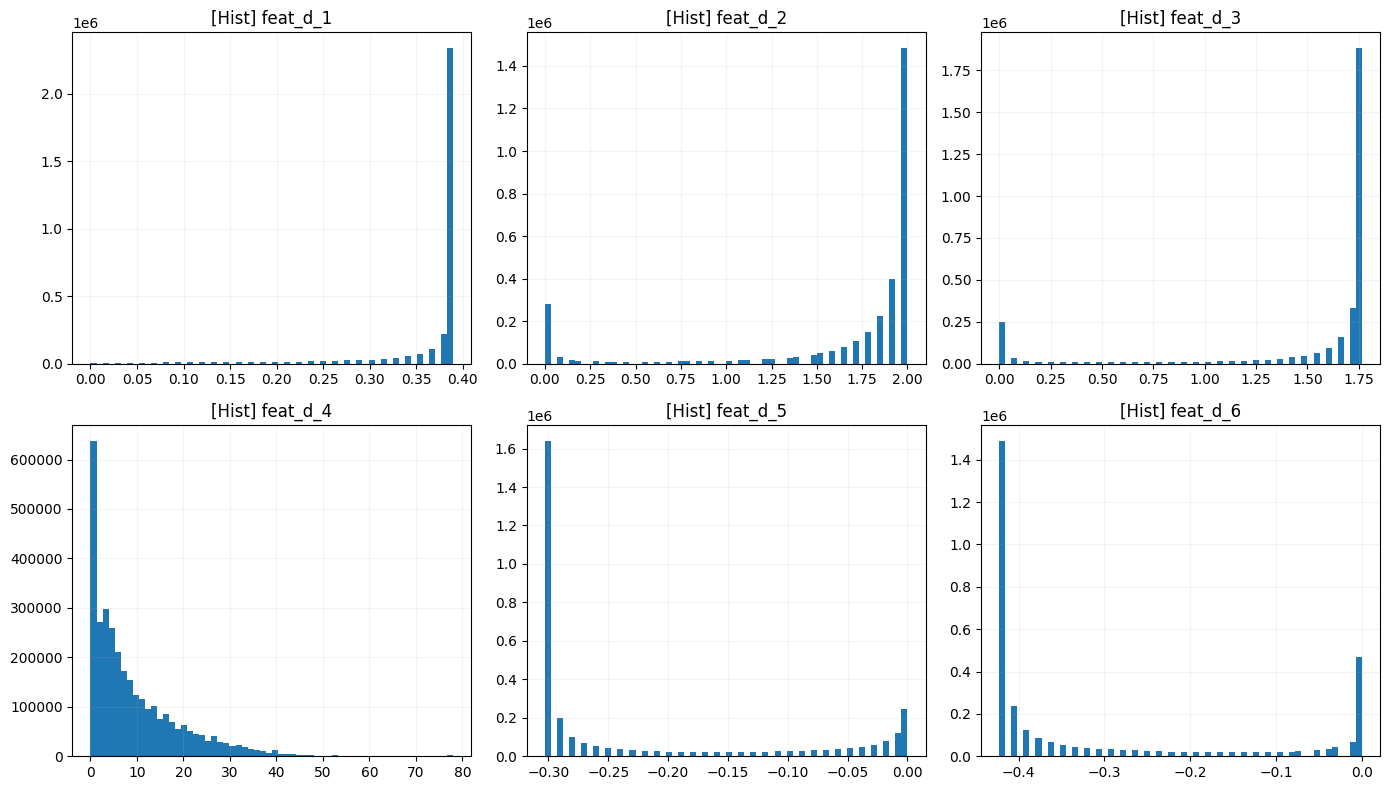

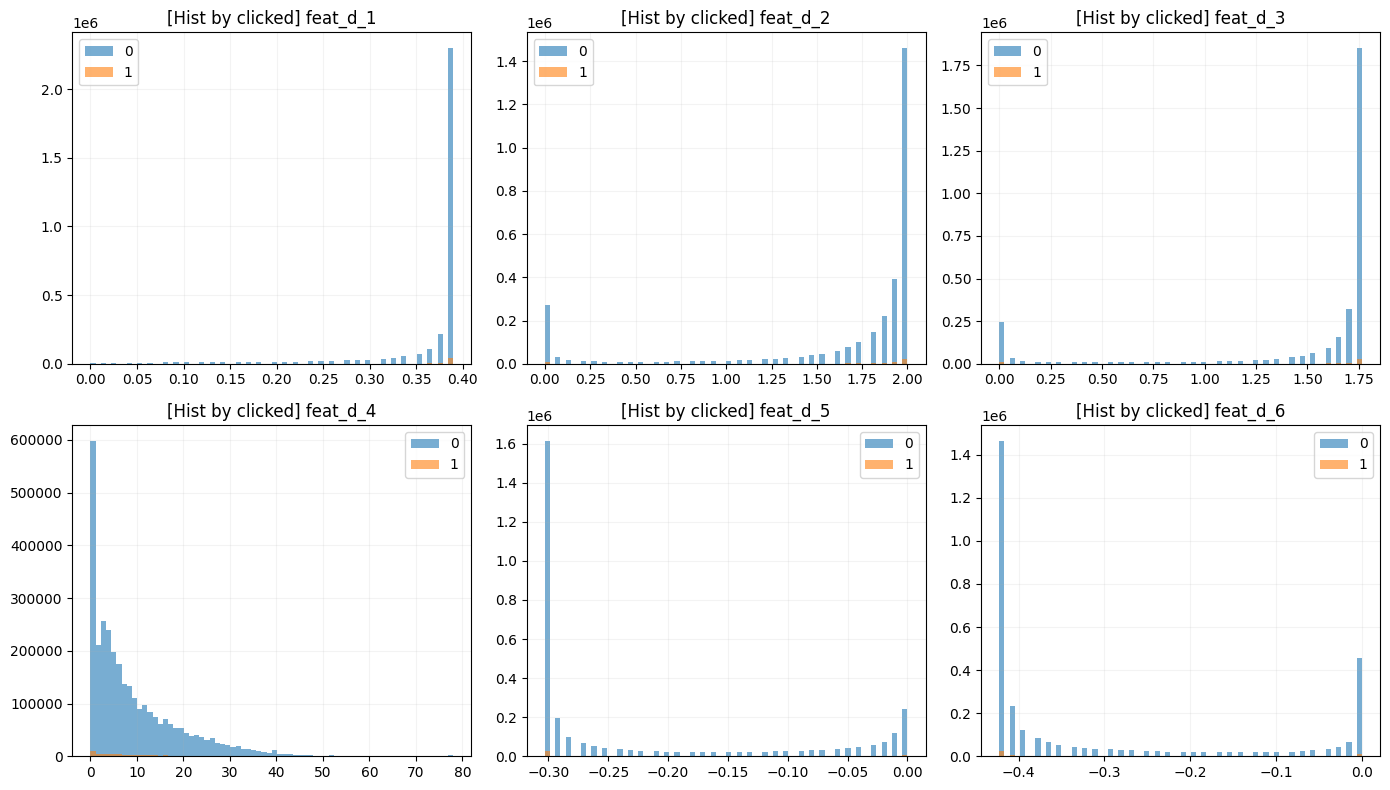

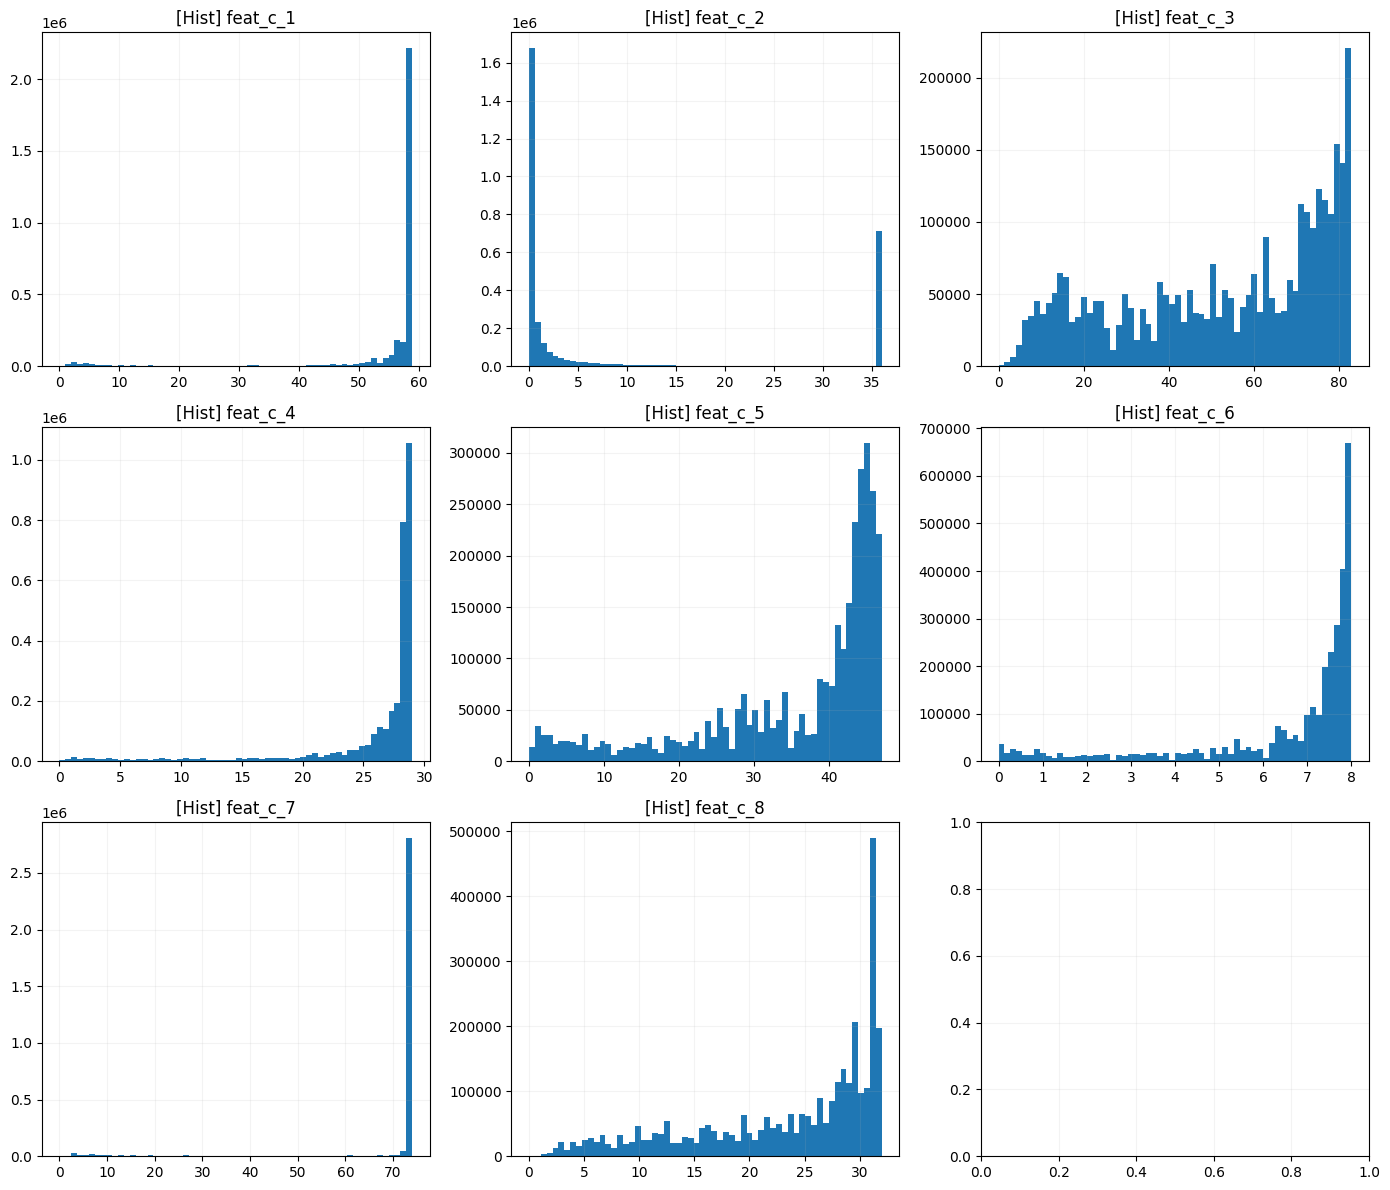

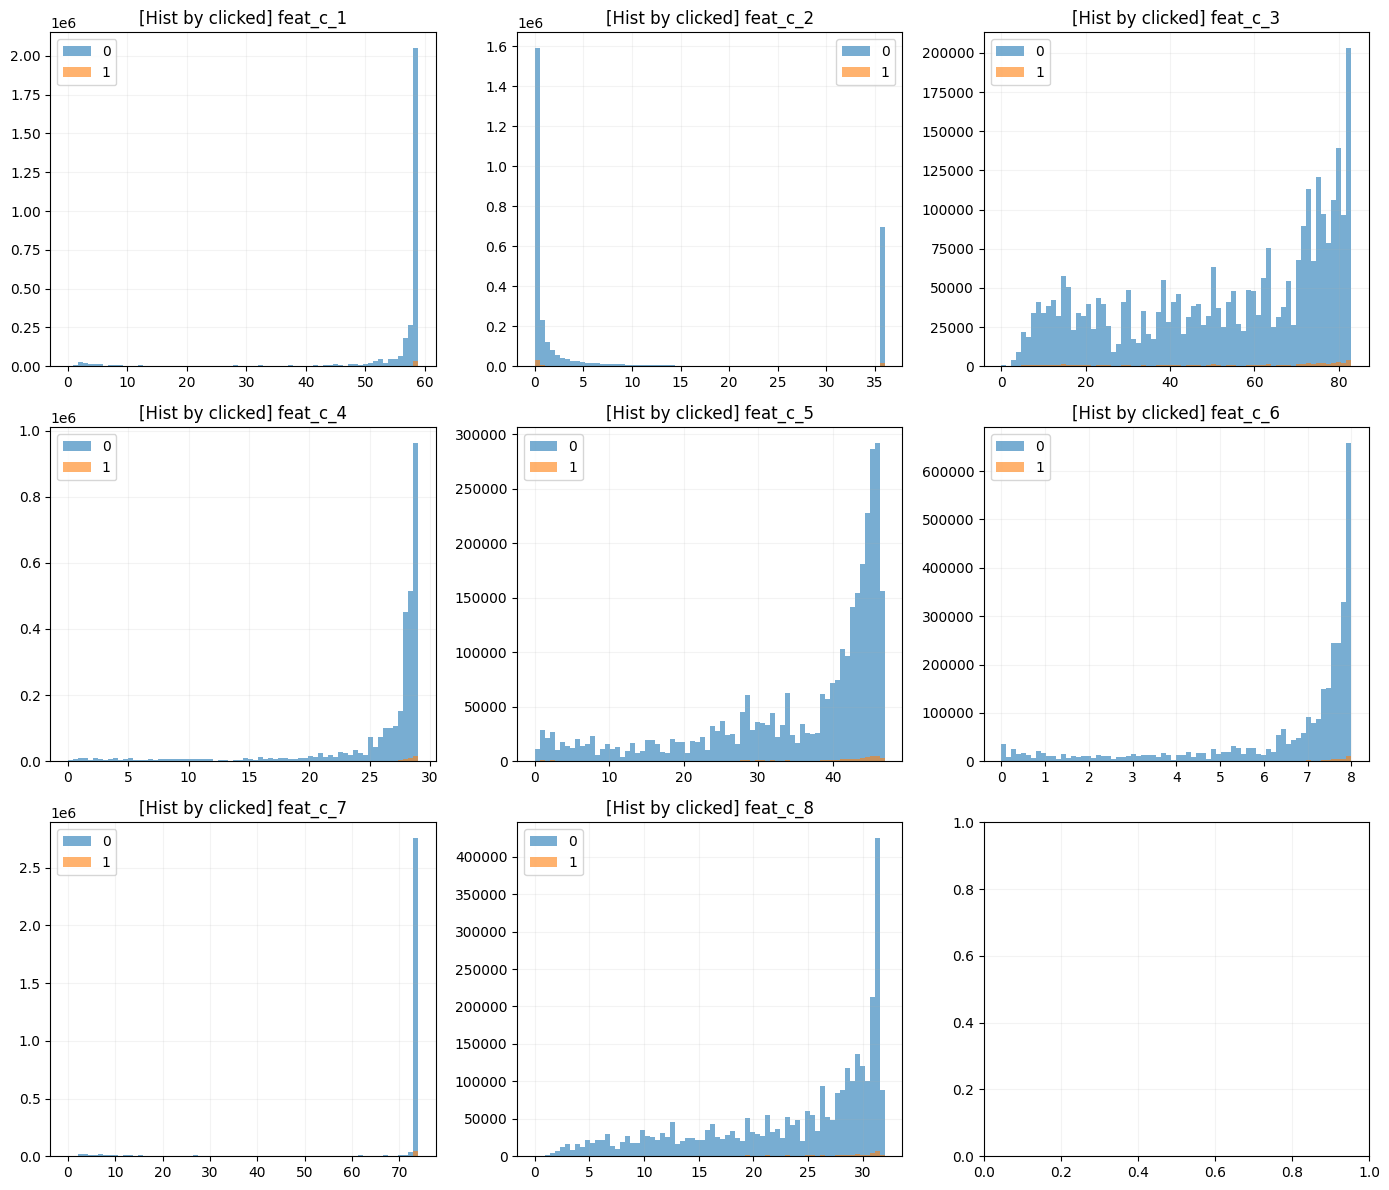

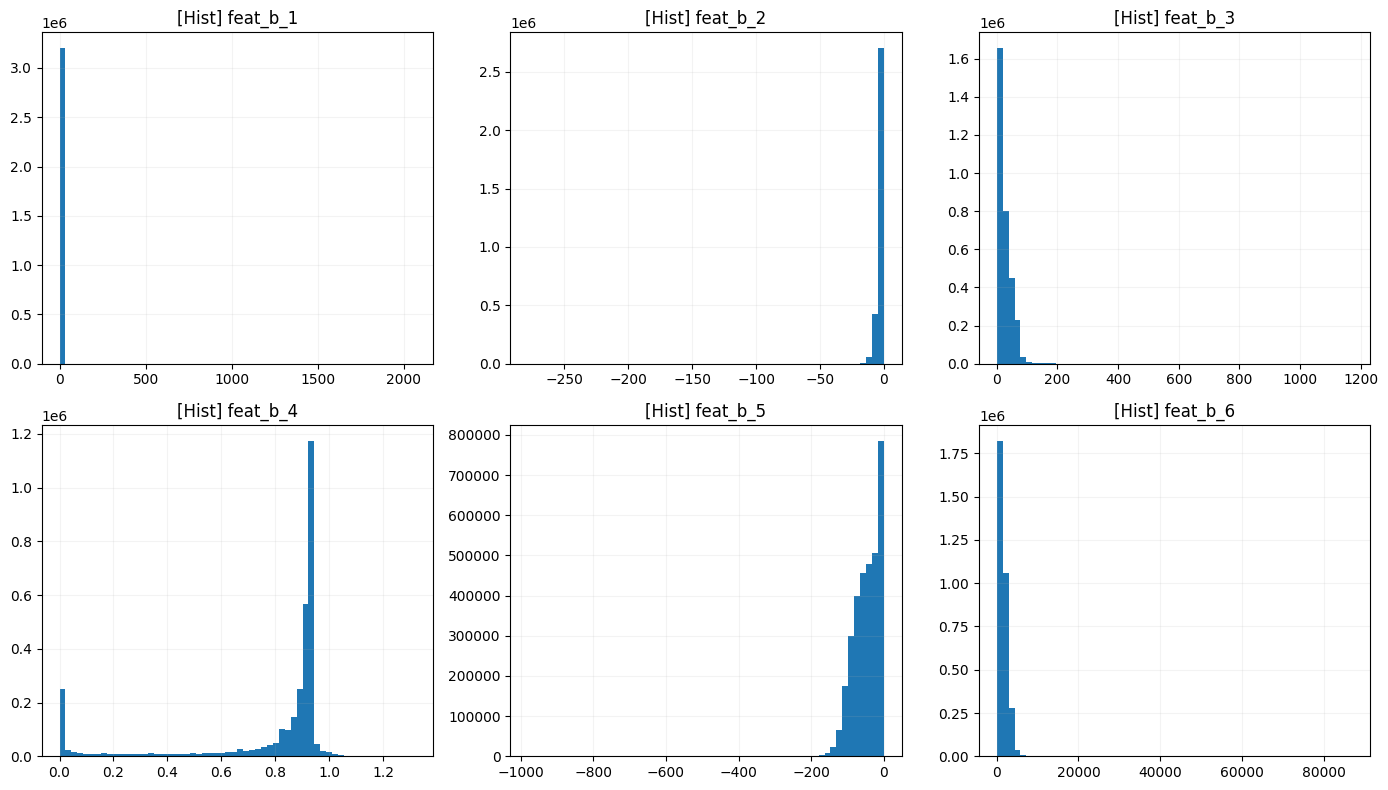

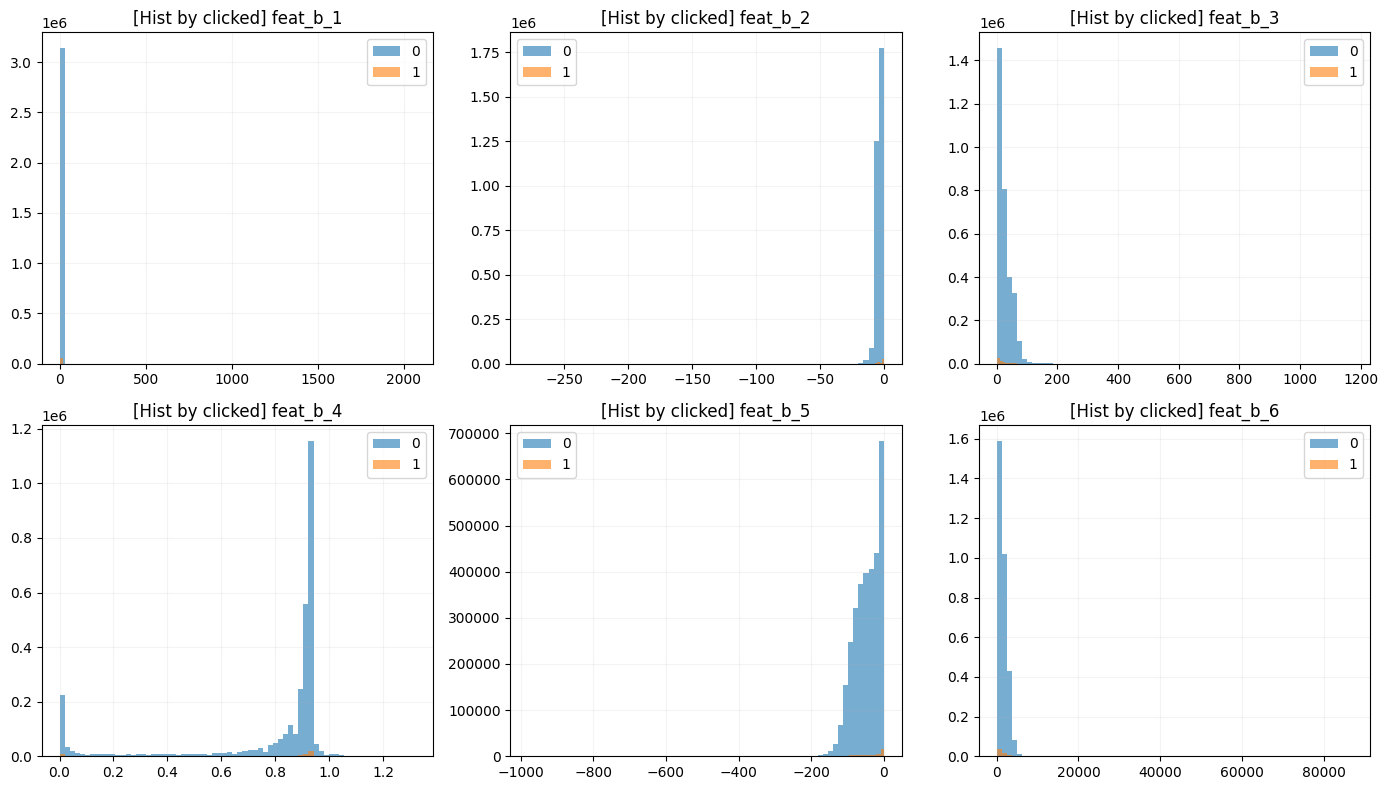

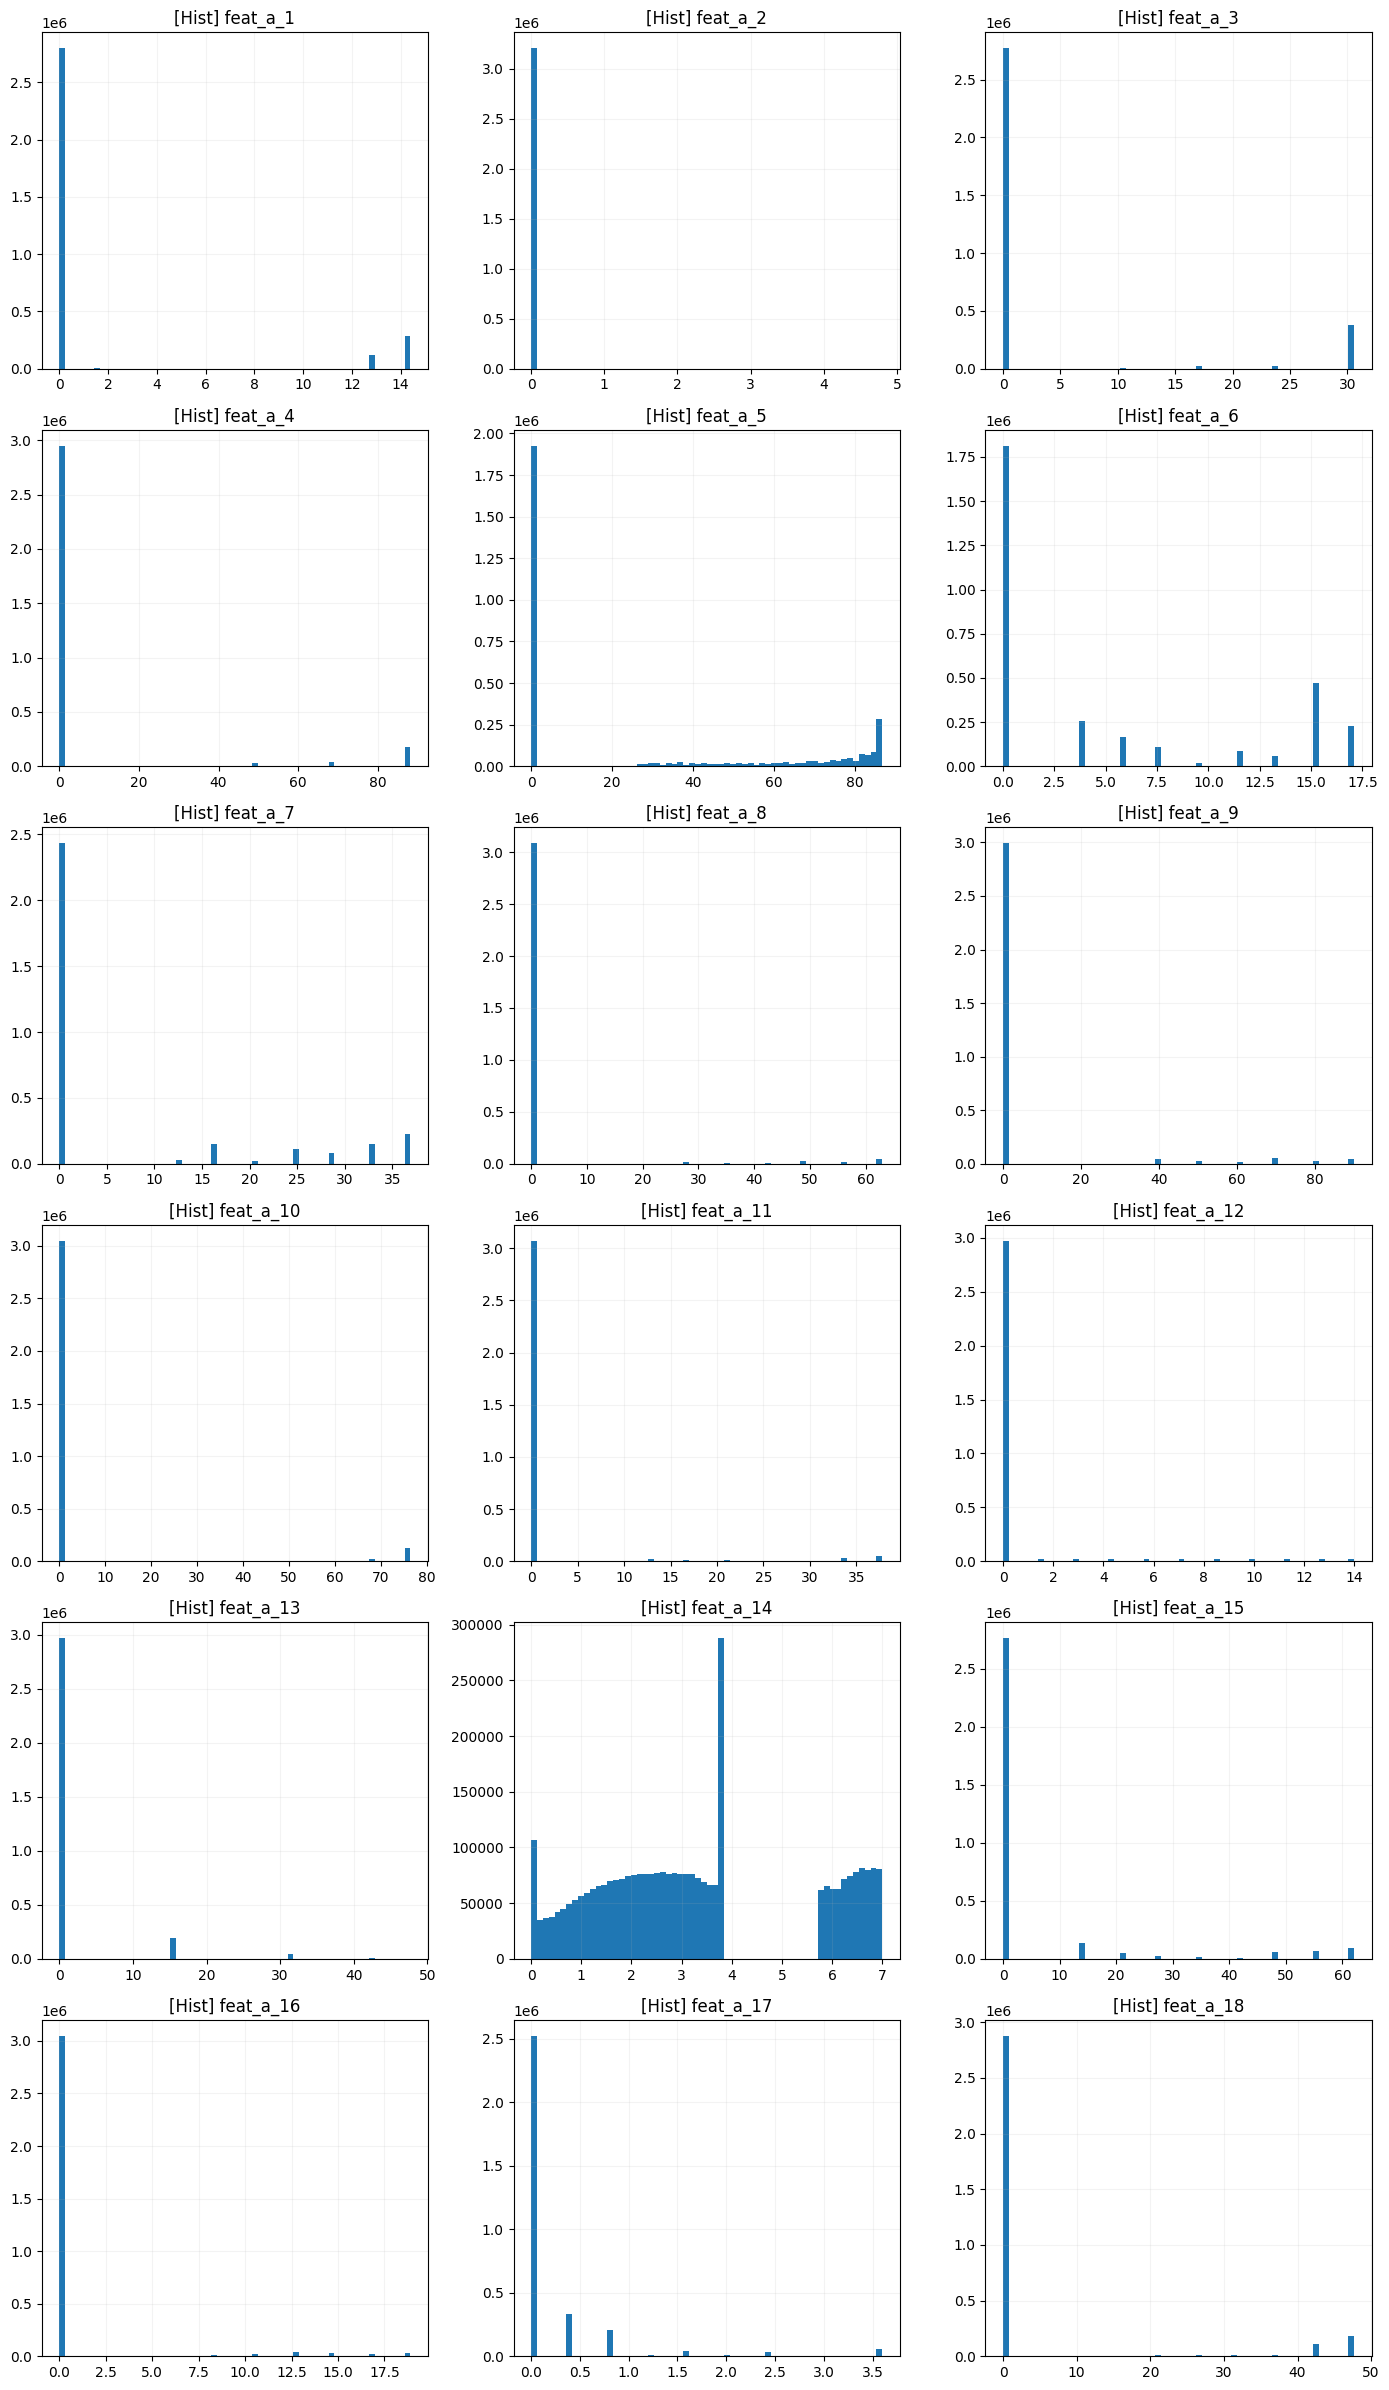

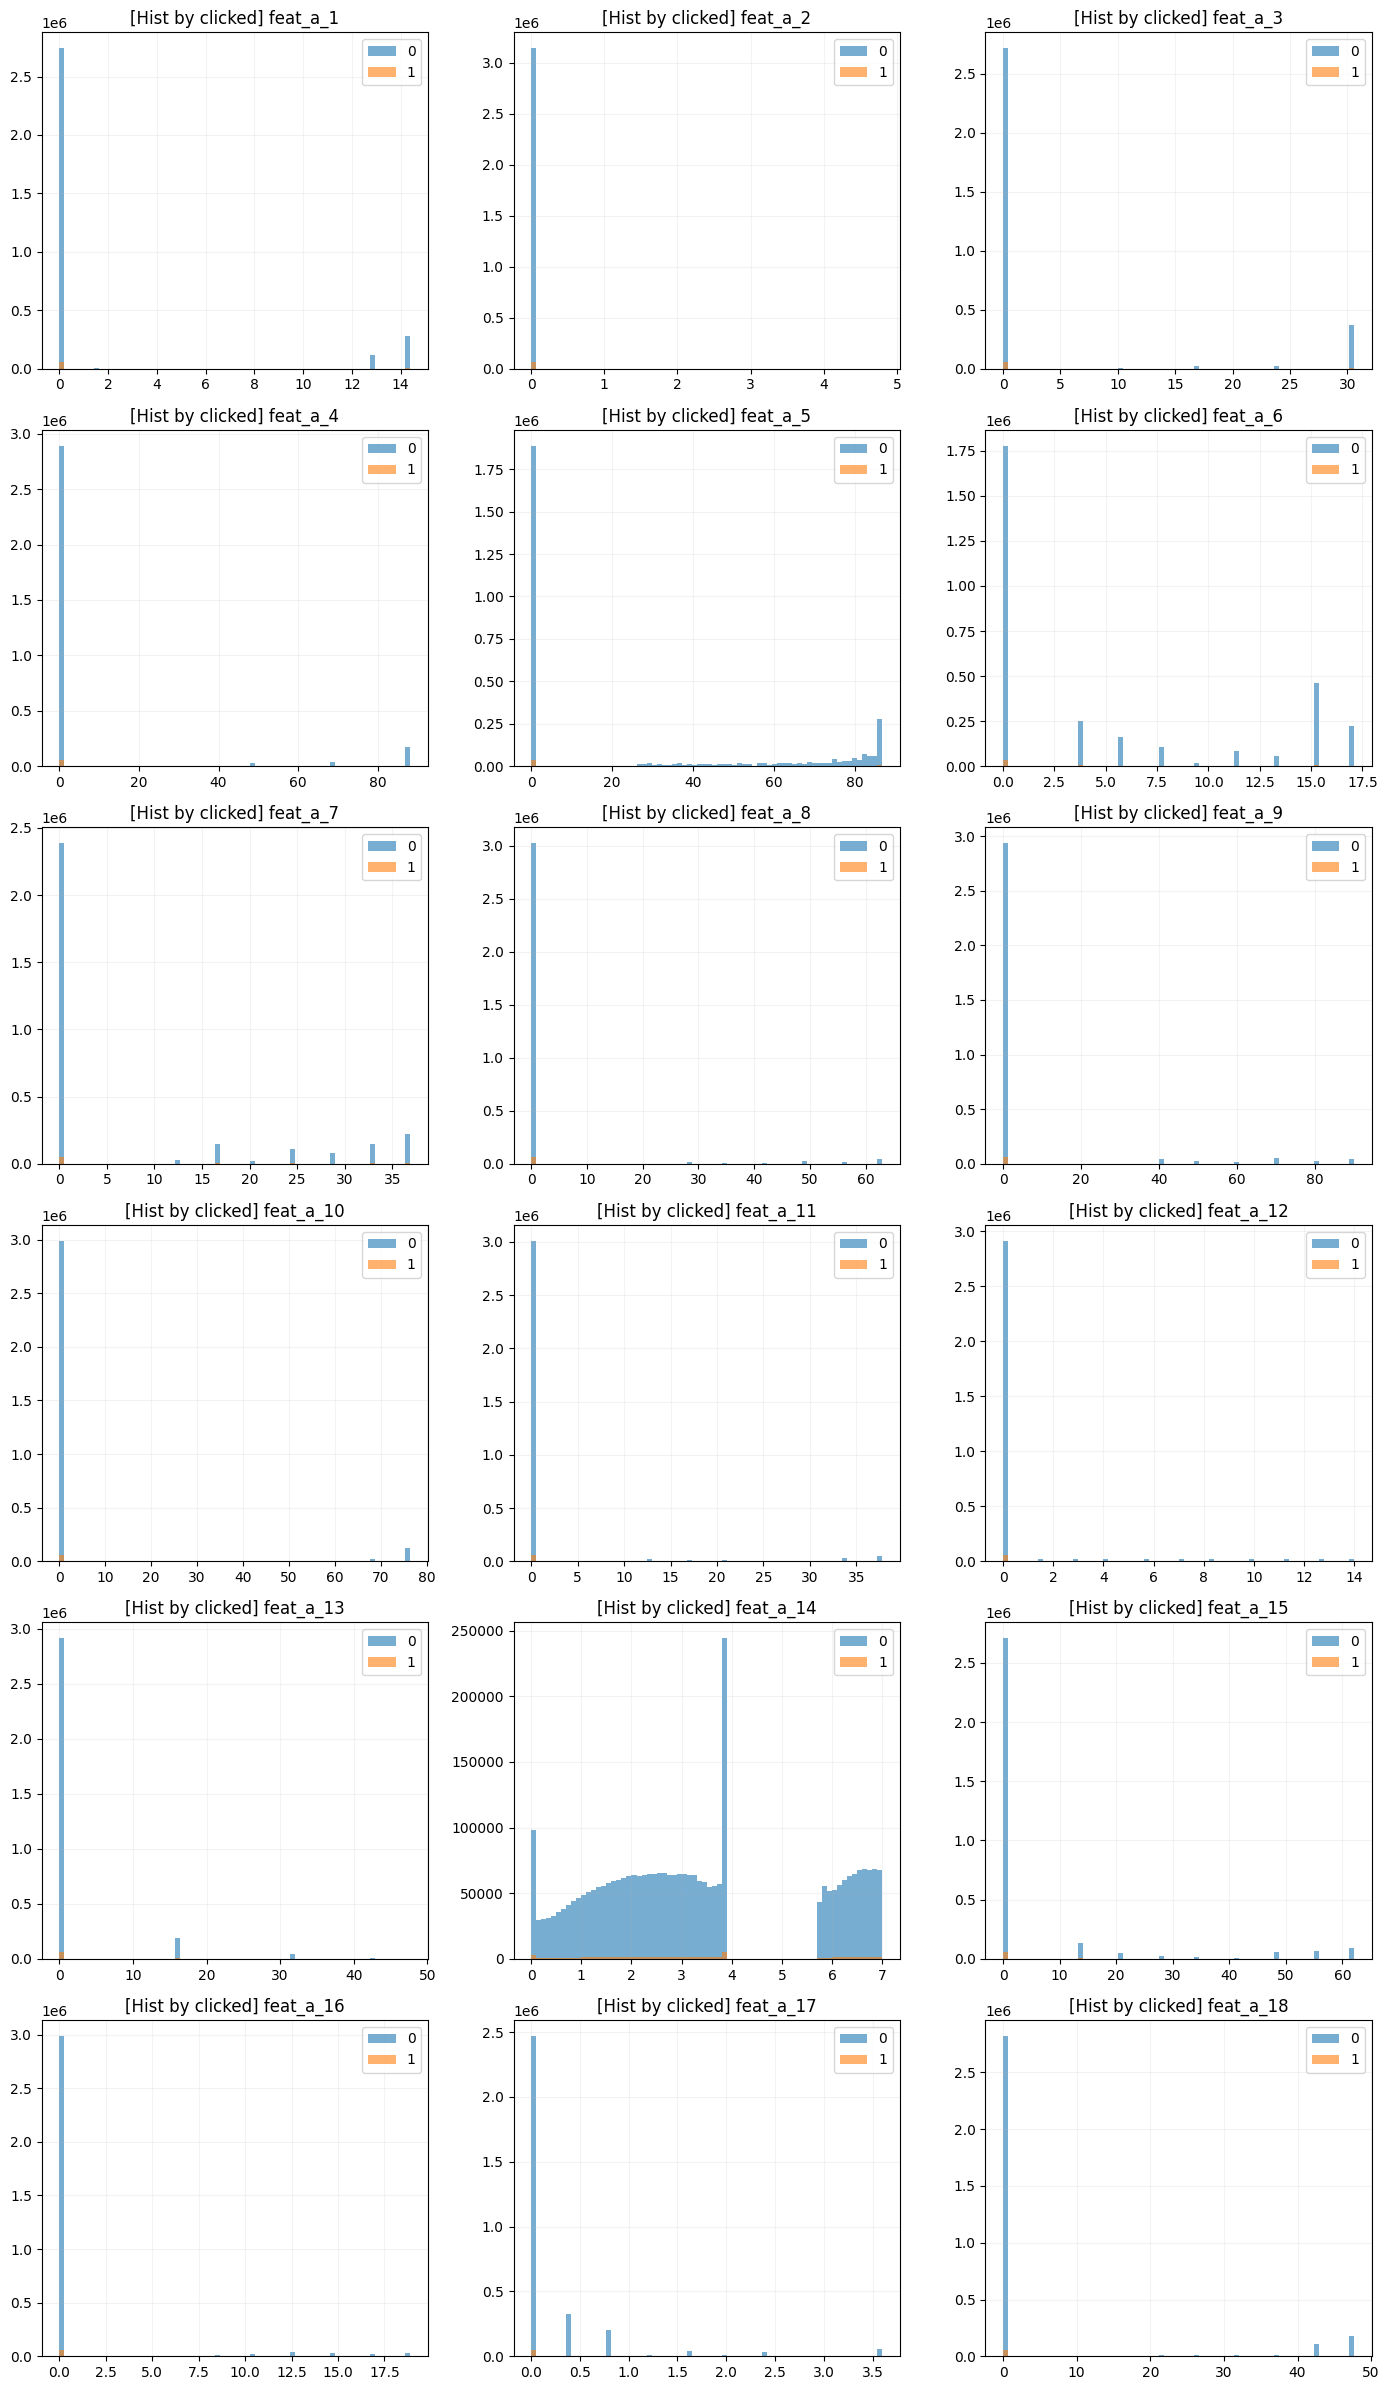

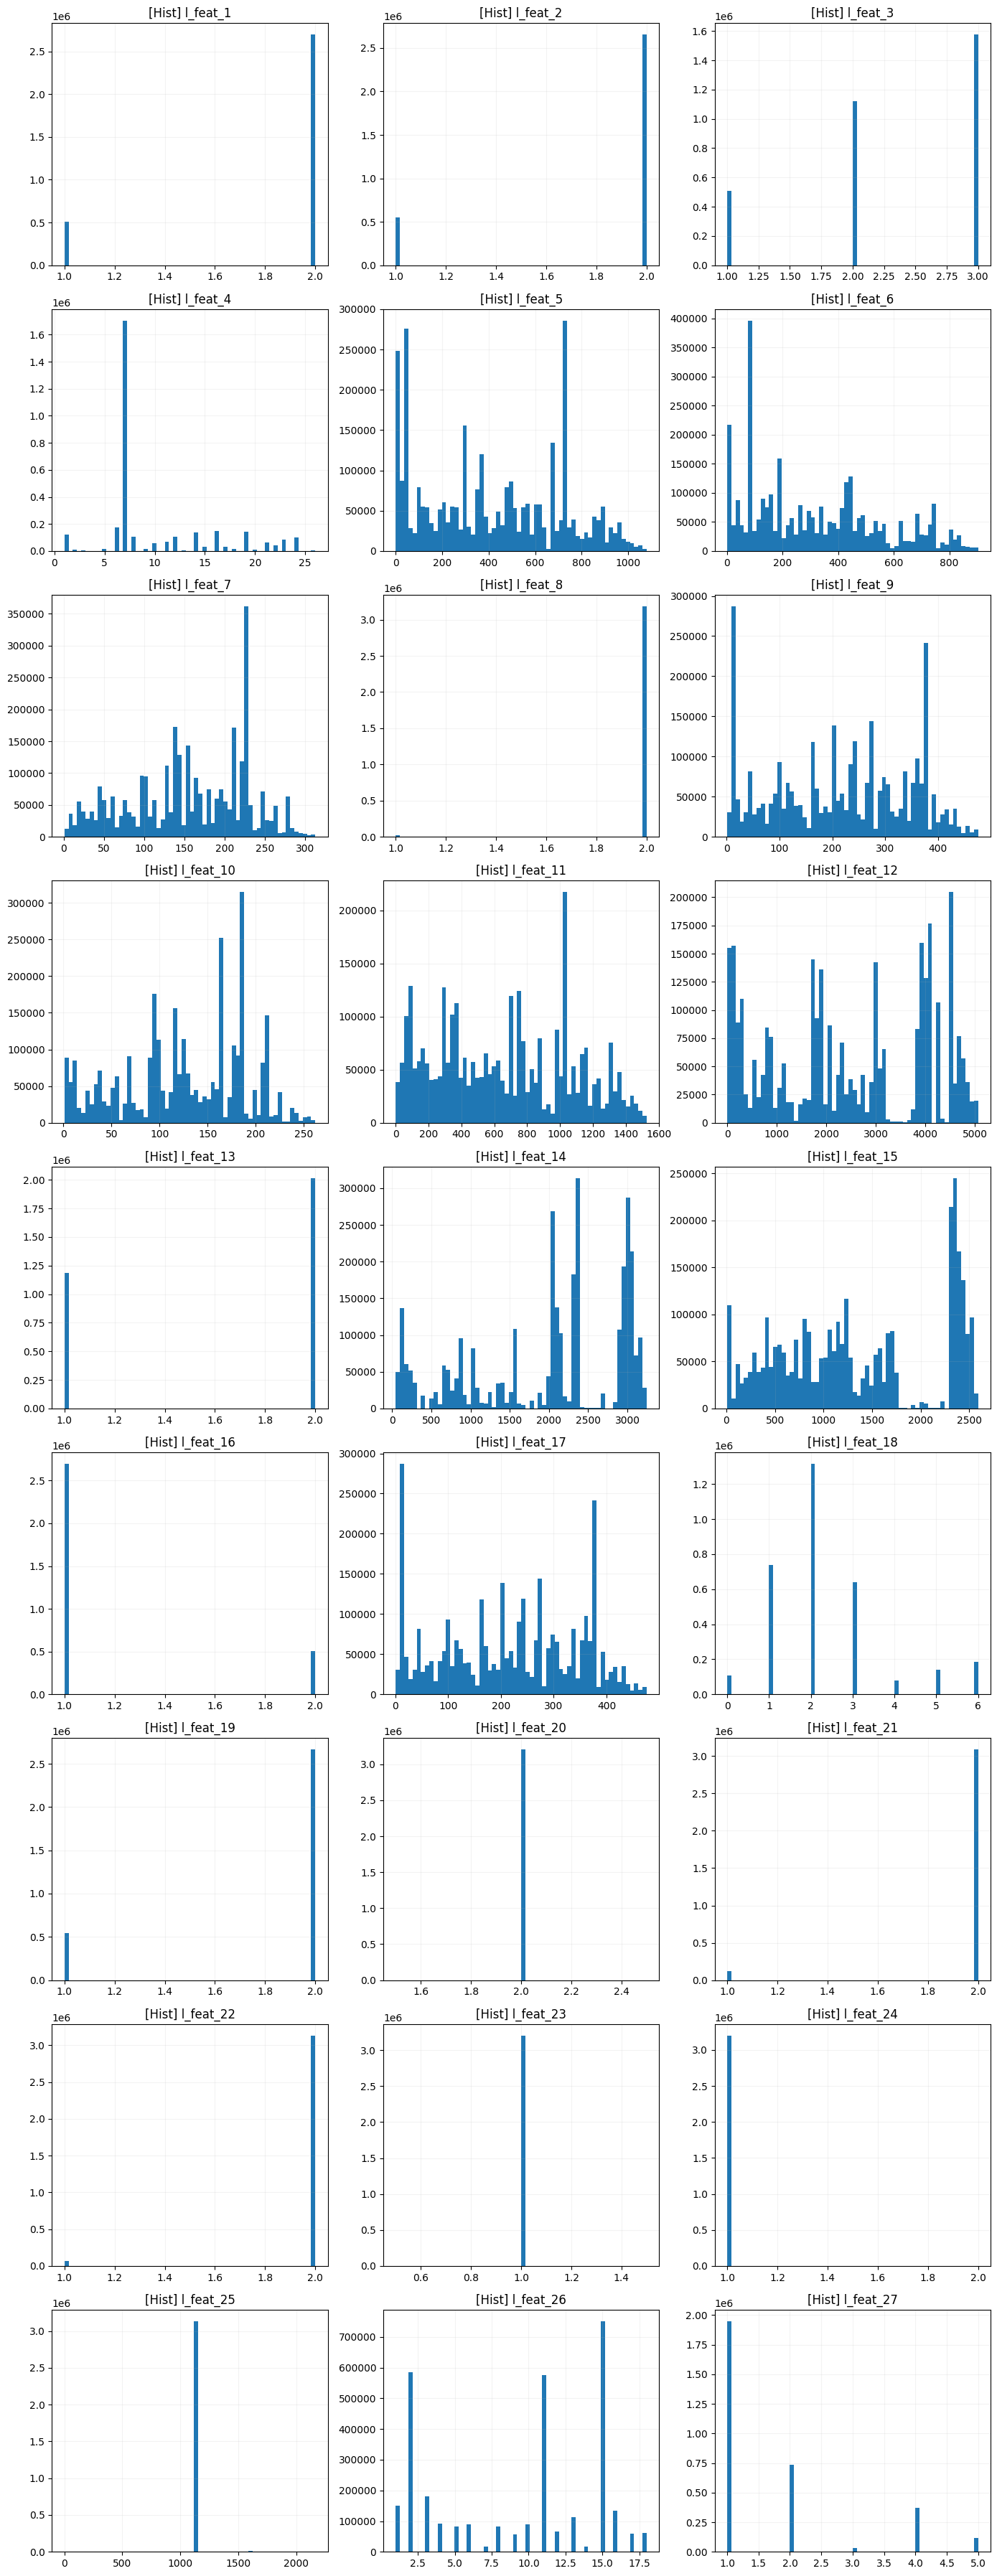

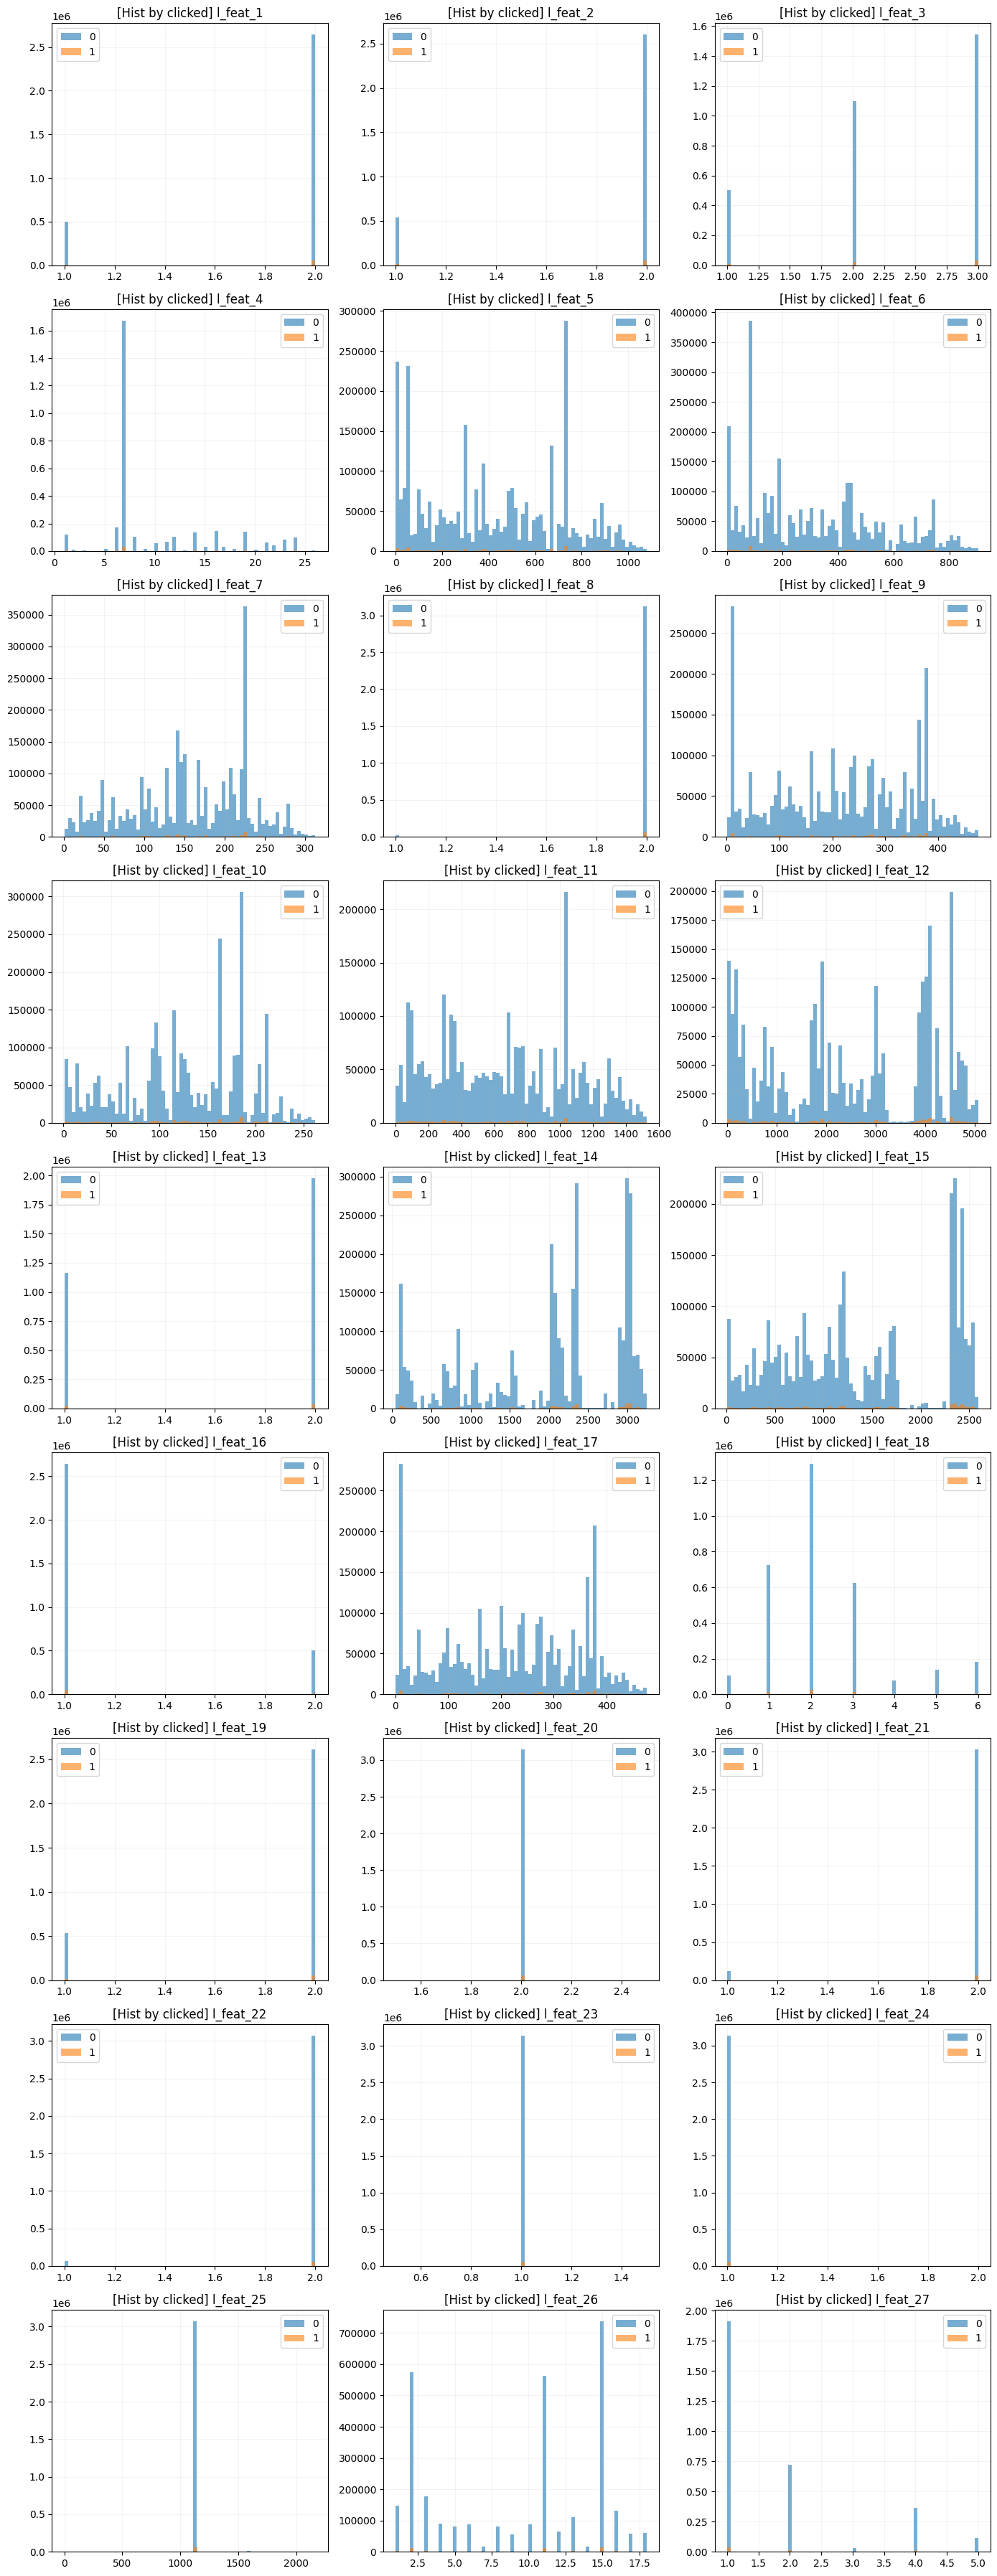

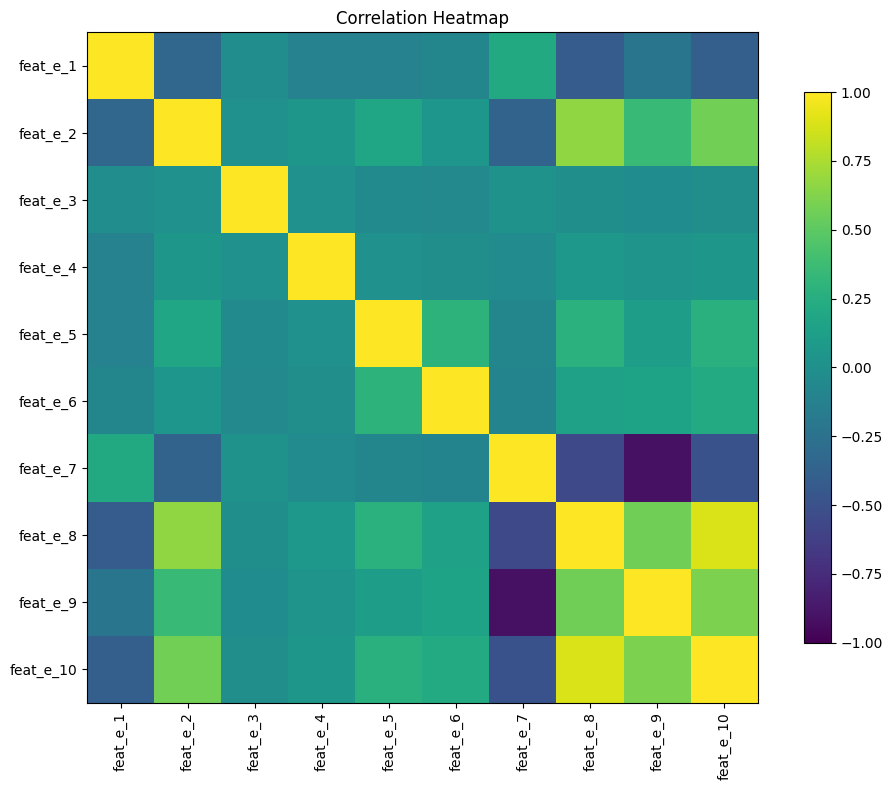

/tmp/ipython-input-350534676.py:175: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


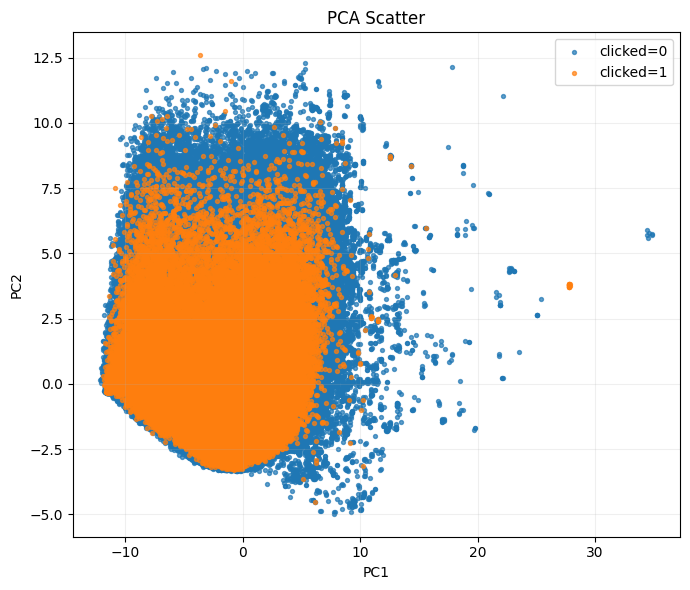

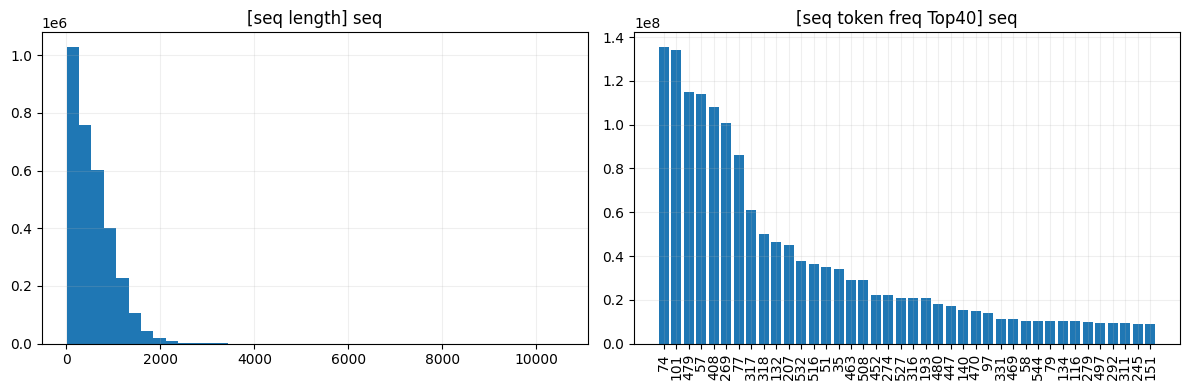

In [13]:
# ---------------------------------------
# 7) 실행 예시
# ---------------------------------------
df = df
target = "clicked"
groups = infer_column_groups(df, target_col=target)

# 범주형
plot_categorical_overview(df, groups["categorical"], target=target, topk=20)

# 연속형 묶음별
for g in ["feat_e", "feat_d", "feat_c", "feat_b", "feat_a", "numeric_others"]:
    if g in groups and groups[g]:
        plot_numeric_distribution(df, groups[g], bins=60)
        plot_numeric_by_target(df, groups[g], target=target, bins=70)

# 상관 히트맵 (예: feat_e만)
if "feat_e" in groups and groups["feat_e"]:
    plot_corr_heatmap(df, groups["feat_e"], vmax=1.0)

# PCA 스캐터 (예: feat_e + feat_d 합쳐서)
pca_cols = []
for g in ["feat_e", "feat_d", "feat_c", "feat_b", "feat_a"]:
    if g in groups and groups[g]:
        pca_cols += groups[g]
pca_cols = pca_cols[:150]  # 너무 많으면 계산량 줄이기
plot_pca_scatter(df, pca_cols, target=target, scale=True)

# 시퀀스
plot_seq_length_and_top_tokens(df, seq_col="seq", topk=40)

In [14]:
# ---------------------------------------
# 6-b) HISTORY 유틸 (history_a_*, history_b_* 전용)
# ---------------------------------------
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_hist_suffix_re = re.compile(r".*?_(\d+)$")

def get_history_cols(df, prefix):
    """prefix='history_a_' 처럼 주면 suffix 숫자 기준으로 정렬된 칼럼 리스트를 돌려준다."""
    cols = [c for c in df.columns if c.startswith(prefix)]
    def _key(c):
        m = _hist_suffix_re.match(c)
        return int(m.group(1)) if m else 10**9
    return sorted(cols, key=_key)

def get_history_matrix(df, prefix, dropna=True):
    """history_* 칼럼들을 suffix 순서로 정렬해 (N,T) 2D numpy 배열로 반환한다."""
    cols = get_history_cols(df, prefix)
    if not cols:
        return None, []
    mat = df[cols].apply(pd.to_numeric, errors="coerce").values
    if dropna:
        # 전구간이 NaN인 행 제거
        keep = ~np.all(np.isnan(mat), axis=1)
        mat = mat[keep]
    return mat, cols

def _nanmean(a, axis=0):
    with np.errstate(invalid='ignore'):
        return np.nanmean(a, axis=axis)

def _nanstd(a, axis=0):
    with np.errstate(invalid='ignore'):
        return np.nanstd(a, axis=axis)

# ---------------------------------------
# 6-c) HISTORY: 전체 평균/표준편차 라인 플롯
# ---------------------------------------
def plot_history_mean_std(df, prefix, title=None):
    """
    각 시점별 평균과 표준편차를 그린다.
    평균 라인과 ±1σ 밴드를 한 Figure에 표시한다.
    """
    mat, cols = get_history_matrix(df, prefix)
    if mat is None:
        return
    mean = _nanmean(mat, axis=0)
    std = _nanstd(mat, axis=0)
    t = np.arange(len(cols)) + 1

    plt.figure(figsize=(9, 4))
    plt.plot(t, mean, label="mean")
    # 표준편차 밴드
    upper = mean + std
    lower = mean - std
    plt.fill_between(t, lower, upper, alpha=0.2, label="±1σ")
    plt.title(title or f"{prefix} mean ± std")
    plt.xlabel("t (position)")
    plt.ylabel("value")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 6-d) HISTORY: 클릭 타겟별 평균 곡선 비교
# ---------------------------------------
def plot_history_mean_by_target(df, prefix, target="clicked", title=None):
    """
    clicked=0 vs 1 각각 평균 시계열을 한 Figure에 비교한다.
    """
    cols = get_history_cols(df, prefix)
    if not cols or target not in df.columns:
        return
    sub = df[cols + [target]].copy()
    for c in cols:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    t = np.arange(len(cols)) + 1
    plt.figure(figsize=(9, 4))
    for cls in sorted(sub[target].dropna().unique()):
        mean = _nanmean(sub.loc[sub[target]==cls, cols].values, axis=0)
        plt.plot(t, mean, label=f"{target}={int(cls)}")
    plt.title(title or f"{prefix} mean by {target}")
    plt.xlabel("t (position)")
    plt.ylabel("value")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 6-e) HISTORY: 롤링(슬라이딩 윈도우) 평균/변동성
# ---------------------------------------
def plot_history_rolling(df, prefix, window=5, agg="mean", title=None):
    """
    각 시점의 시계열을 window 길이로 롤링한 뒤, 행(샘플) 방향 평균을 그린다.
    agg: "mean" | "std"
    """
    mat, cols = get_history_matrix(df, prefix)
    if mat is None:
        return
    # (N,T) -> 전체 샘플 평균을 구하기 전에 시점별 롤링
    T = len(cols)
    # 롤링을 위해 각 시점마다 window 평균(또는 std)을 계산
    rolled = []
    for i in range(T):
        start = max(0, i - window + 1)
        window_slice = mat[:, start:i+1]
        if agg == "std":
            rolled.append(_nanstd(window_slice, axis=1))
        else:
            rolled.append(_nanmean(window_slice, axis=1))
    rolled = np.array(rolled).T  # (N,T)

    # 샘플 평균 곡선
    mean_curve = _nanmean(rolled, axis=0)
    t = np.arange(T) + 1
    plt.figure(figsize=(9, 4))
    plt.plot(t, mean_curve, label=f"rolling-{agg} (w={window})")
    plt.title(title or f"{prefix} rolling {agg} (window={window})")
    plt.xlabel("t (position)")
    plt.ylabel(agg)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 6-f) HISTORY: 타겟별 롤링 평균 비교
# ---------------------------------------
def plot_history_rolling_by_target(df, prefix, target="clicked", window=5, title=None):
    cols = get_history_cols(df, prefix)
    if not cols or target not in df.columns:
        return
    sub = df[cols + [target]].copy()
    for c in cols:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")
    T = len(cols)
    t = np.arange(T) + 1

    plt.figure(figsize=(9, 4))
    for cls in sorted(sub[target].dropna().unique()):
        m = sub[target]==cls
        mat = sub.loc[m, cols].values  # (Nc, T)
        rolled = []
        for i in range(T):
            start = max(0, i - window + 1)
            window_slice = mat[:, start:i+1]
            rolled.append(_nanmean(window_slice, axis=1))
        rolled = np.array(rolled).T  # (Nc, T)
        mean_curve = _nanmean(rolled, axis=0)
        plt.plot(t, mean_curve, label=f"{target}={int(cls)}")
    plt.title(title or f"{prefix} rolling mean by {target} (w={window})")
    plt.xlabel("t (position)")
    plt.ylabel("rolling mean")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 6-g) HISTORY: 위치×값 히트맵 (전체 평균)
# ---------------------------------------
def plot_history_heatmap(df, prefix, vmax=None, title=None):
    """
    각 시점별 평균값을 1×T 히트맵처럼 시각화한다.
    값의 크기를 직관적으로 비교할 때 유용하다.
    """
    mat, cols = get_history_matrix(df, prefix)
    if mat is None:
        return
    mean = _nanmean(mat, axis=0)[None, :]  # (1, T)
    fig, ax = plt.subplots(figsize=(max(6, len(cols)*0.25), 2.2))
    im = ax.imshow(mean, aspect='auto', vmin=None, vmax=vmax)
    ax.set_yticks([0]); ax.set_yticklabels(["mean"])
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels([str(i+1) for i in range(len(cols))], rotation=90)
    ax.set_title(title or f"{prefix} mean heatmap")
    fig.colorbar(im, ax=ax, fraction=0.03)
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 6-h) HISTORY: 타겟별 히트맵
# ---------------------------------------
def plot_history_heatmap_by_target(df, prefix, target="clicked", vmax=None, title=None):
    """
    clicked=0/1 각각의 시점별 평균을 2×T 히트맵으로 그린다.
    """
    cols = get_history_cols(df, prefix)
    if not cols or target not in df.columns:
        return
    sub = df[cols + [target]].copy()
    for c in cols:
        sub[c] = pd.to_numeric(sub[c], errors="coerce")

    rows = []
    ylabels = []
    for cls in sorted(sub[target].dropna().unique()):
        mean = _nanmean(sub.loc[sub[target]==cls, cols].values, axis=0)
        rows.append(mean)
        ylabels.append(f"{target}={int(cls)}")
    data = np.vstack(rows) if rows else None
    if data is None:
        return

    fig, ax = plt.subplots(figsize=(max(6, len(cols)*0.25), 1.5*len(ylabels)))
    im = ax.imshow(data, aspect='auto', vmin=None, vmax=vmax)
    ax.set_yticks(np.arange(len(ylabels))); ax.set_yticklabels(ylabels)
    ax.set_xticks(np.arange(len(cols)))
    ax.set_xticklabels([str(i+1) for i in range(len(cols))], rotation=90)
    ax.set_title(title or f"{prefix} mean heatmap by {target}")
    fig.colorbar(im, ax=ax, fraction=0.03)
    plt.tight_layout()
    plt.show()


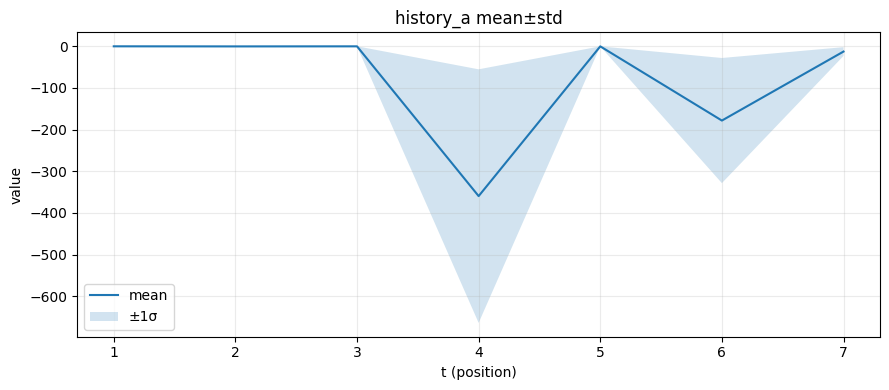

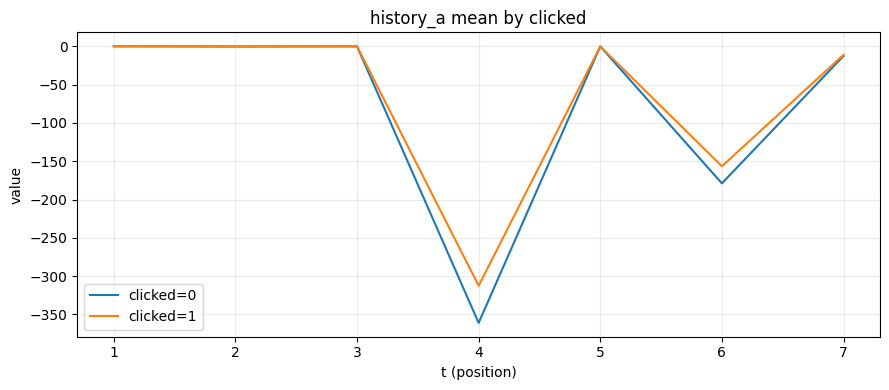

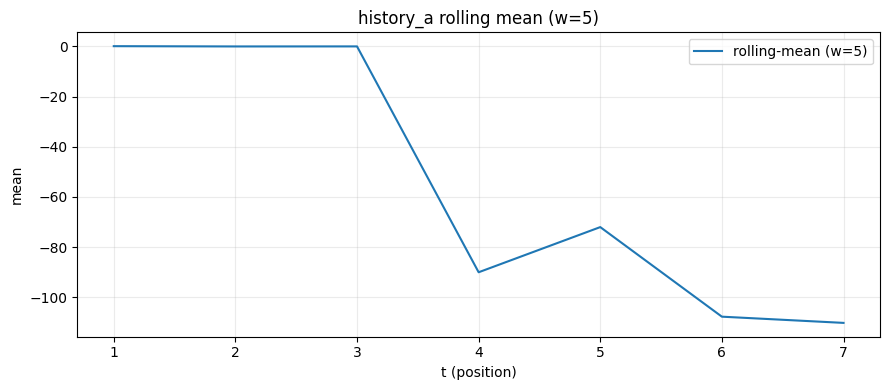

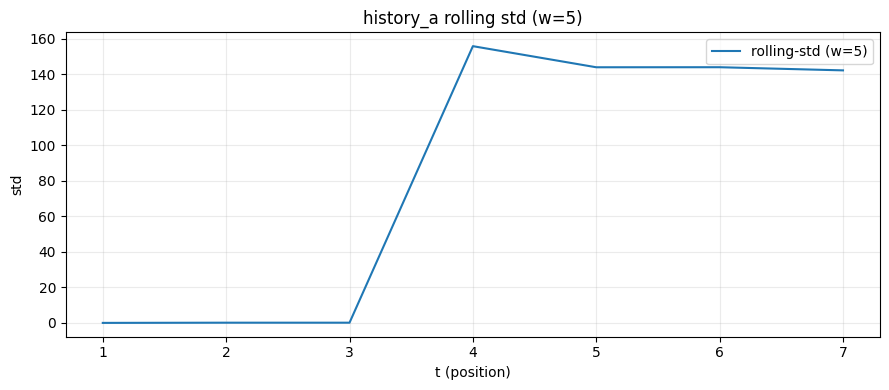

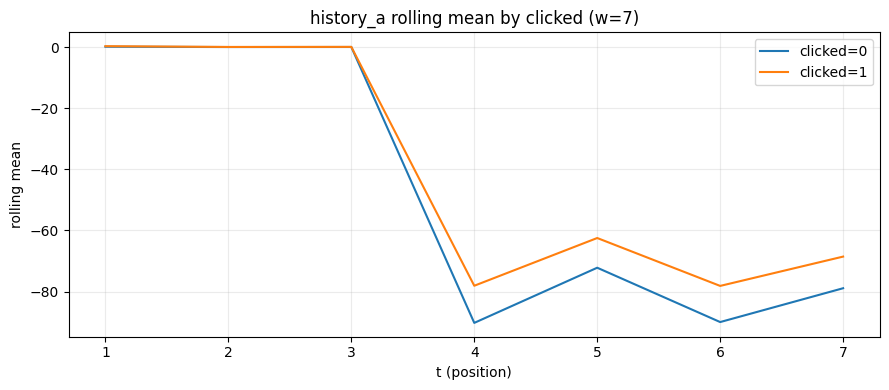

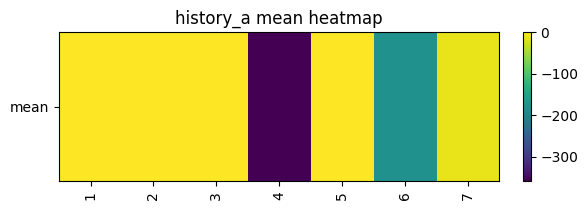

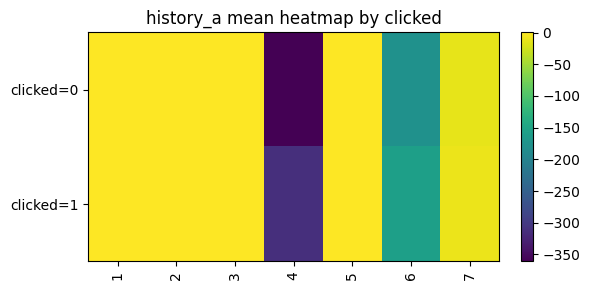

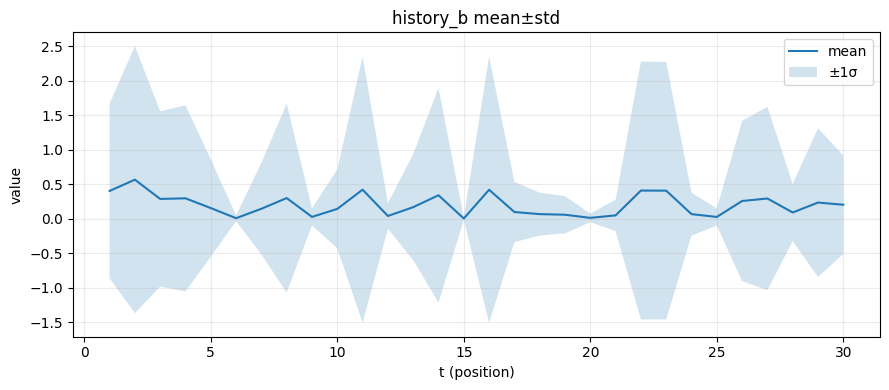

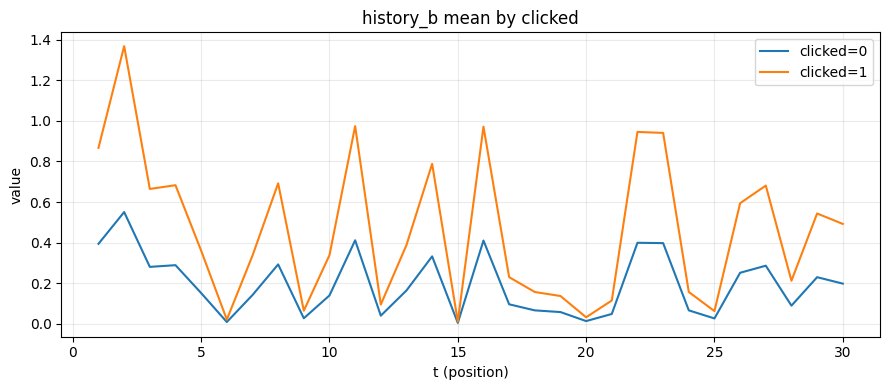

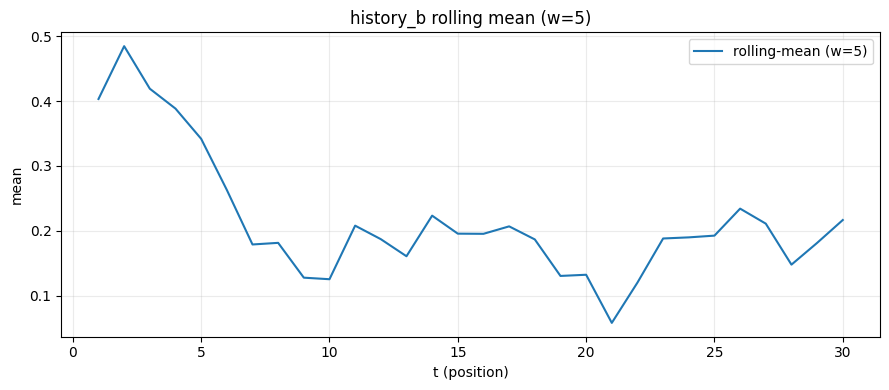

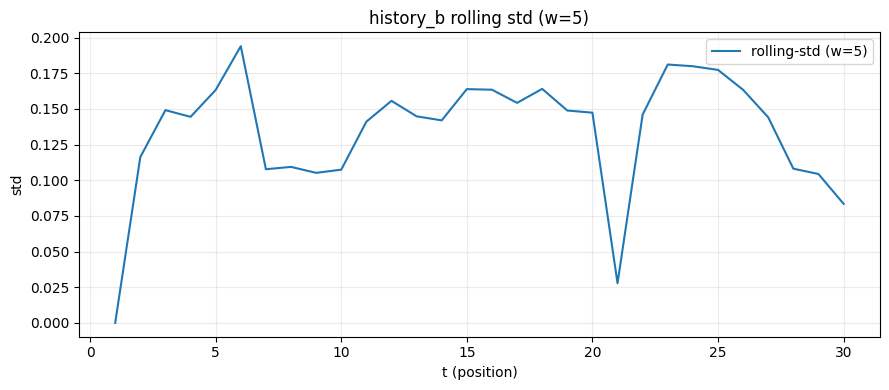

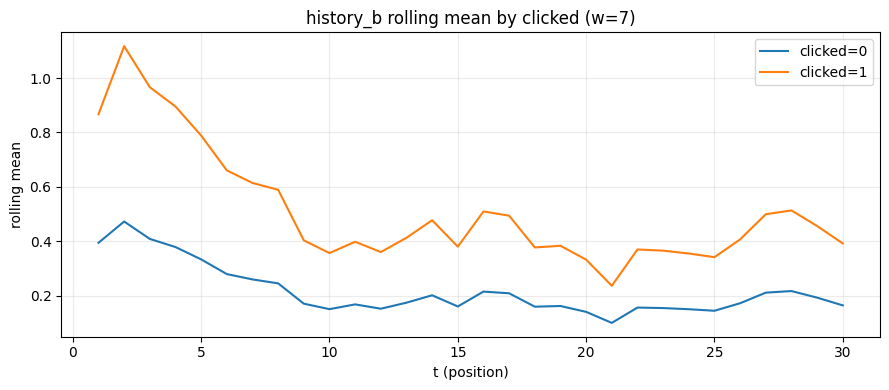

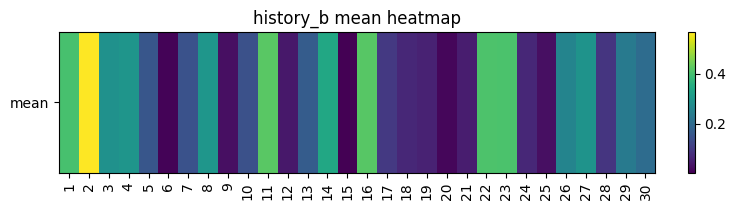

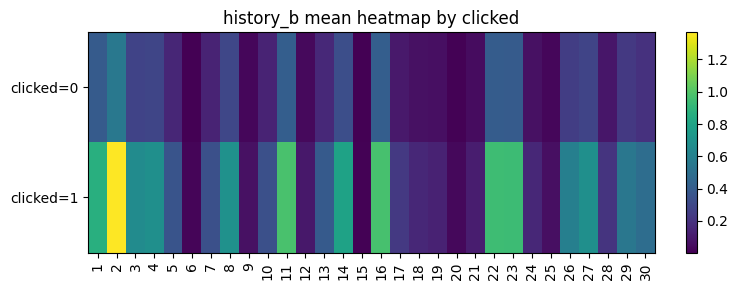

In [15]:

# ---------------------------------------
# 6-i) HISTORY 실행 예시
# ---------------------------------------
# history_a_* 전처리/시각화
plot_history_mean_std(df, "history_a_", title="history_a mean±std")
plot_history_mean_by_target(df, "history_a_", target="clicked", title="history_a mean by clicked")
plot_history_rolling(df, "history_a_", window=5, agg="mean", title="history_a rolling mean (w=5)")
plot_history_rolling(df, "history_a_", window=5, agg="std",  title="history_a rolling std (w=5)")
plot_history_rolling_by_target(df, "history_a_", target="clicked", window=7, title="history_a rolling mean by clicked (w=7)")
plot_history_heatmap(df, "history_a_", title="history_a mean heatmap")
plot_history_heatmap_by_target(df, "history_a_", target="clicked", title="history_a mean heatmap by clicked")

# history_b_* 전처리/시각화
plot_history_mean_std(df, "history_b_", title="history_b mean±std")
plot_history_mean_by_target(df, "history_b_", target="clicked", title="history_b mean by clicked")
plot_history_rolling(df, "history_b_", window=5, agg="mean", title="history_b rolling mean (w=5)")
plot_history_rolling(df, "history_b_", window=5, agg="std",  title="history_b rolling std (w=5)")
plot_history_rolling_by_target(df, "history_b_", target="clicked", window=7, title="history_b rolling mean by clicked (w=7)")
plot_history_heatmap(df, "history_b_", title="history_b mean heatmap")
plot_history_heatmap_by_target(df, "history_b_", target="clicked", title="history_b mean heatmap by clicked")

In [18]:
# ---------------------------------------
# 6-j) SEQ: 토큰/포지션 분석 유틸 (fixed)
# ---------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def parse_seq_column(series):
    out = []
    for v in series.fillna(""):
        if isinstance(v, list):
            toks = [str(t).strip() for t in v if str(t).strip() != ""]
        else:
            s = str(v).strip()
            toks = [t.strip() for t in s.split(",") if t.strip() != ""]
        out.append(toks)
    return out

def seq_top_tokens(seqs, topk=50):
    cnt = Counter(t for s in seqs for t in s)
    if topk is None or topk <= 0:
        return list(cnt.keys())
    return [tok for tok, _ in cnt.most_common(topk)]

def build_token_position_matrix(seqs, top_tokens, max_len=50, normalize="row"):
    """
    seqs: 리스트의 리스트
    top_tokens: 행 인덱스로 쓸 토큰 리스트
    max_len: 열 포지션 길이(1..max_len)
    normalize: None | "row" | "col" | "all"
    반환: (mat, row_labels, col_labels)
    """
    if not top_tokens or max_len <= 0:
        return np.zeros((0, 0)), [], []

    tok2idx = {tok: i for i, tok in enumerate(top_tokens)}
    T = len(top_tokens)
    L = max_len
    mat = np.zeros((T, L), dtype=float)

    for s in seqs:
        if not s:
            continue
        for pos, tok in enumerate(s[:L], start=1):
            ridx = tok2idx.get(tok, None)
            if ridx is not None:
                mat[ridx, pos - 1] += 1.0

    if normalize == "row":
        row_sum = mat.sum(axis=1, keepdims=True)
        row_sum[row_sum == 0] = 1.0
        mat = mat / row_sum
    elif normalize == "col":
        col_sum = mat.sum(axis=0, keepdims=True)
        col_sum[col_sum == 0] = 1.0
        mat = mat / col_sum
    elif normalize == "all":
        s = mat.sum()
        mat = mat / s if s > 0 else mat

    cols = [f"pos{p}" for p in range(1, L + 1)]
    return mat, top_tokens, cols

def plot_token_position_heatmap(mat, row_labels, col_labels, title=None, vmax=None, figsize=None):
    """
    mat: 2D array (rows=tokens, cols=positions)
    """
    # 안전 가드
    if mat is None or len(row_labels) == 0 or len(col_labels) == 0:
        return
    if figsize is None:
        figsize = (10, max(6, 0.22 * len(row_labels)))

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(mat, aspect='auto', vmin=0, vmax=vmax)
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels)
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, rotation=90)
    ax.set_title(title or "Token × Position heatmap")
    fig.colorbar(im, ax=ax, fraction=0.03)
    plt.tight_layout()
    plt.show()

# ---------------------------------------
# 6-k) SEQ: 타겟별 토큰/포지션 히트맵 비교 (fixed)
# ---------------------------------------
def plot_seq_token_position_by_target(df, seq_col="seq", target="clicked",
                                      topk=40, max_len=40, normalize="row"):
    if seq_col not in df.columns or target not in df.columns:
        return
    seqs_all = parse_seq_column(df[seq_col])
    if len(seqs_all) == 0:
        return
    top_tokens = seq_top_tokens(seqs_all, topk=topk)
    if not top_tokens:
        return

    classes = [c for c in sorted(df[target].dropna().unique())]
    for cls in classes:
        sub = df.loc[df[target] == cls]
        if sub.empty:
            continue
        seqs = parse_seq_column(sub[seq_col])
        mat, rows, cols = build_token_position_matrix(
            seqs, top_tokens, max_len=max_len, normalize=normalize
        )
        if len(rows) == 0 or len(cols) == 0:
            continue
        ttl = f"{seq_col} token×position ({target}={int(cls)}, top{topk}, L={max_len}, norm={normalize})"
        plot_token_position_heatmap(mat, rows, cols, title=ttl)

# ---------------------------------------
# 6-l) SEQ: 토큰 전이(빅람) 히트맵 (fixed)
# ---------------------------------------
def build_bigram_matrix(seqs, top_tokens, normalize="row"):
    if not top_tokens:
        return np.zeros((0, 0))
    tok2idx = {tok: i for i, tok in enumerate(top_tokens)}
    n = len(top_tokens)
    M = np.zeros((n, n), dtype=float)
    for s in seqs:
        if not s:
            continue
        for a, b in zip(s, s[1:]):
            i = tok2idx.get(a, None)
            j = tok2idx.get(b, None)
            if i is not None and j is not None:
                M[i, j] += 1.0
    if normalize == "row":
        rs = M.sum(axis=1, keepdims=True)
        rs[rs == 0] = 1.0
        M = M / rs
    elif normalize == "col":
        cs = M.sum(axis=0, keepdims=True)
        cs[cs == 0] = 1.0
        M = M / cs
    elif normalize == "all":
        s = M.sum()
        M = M / s if s > 0 else M
    return M

def plot_bigram_heatmap(df, seq_col="seq", target=None, topk=40, normalize="row"):
    if seq_col not in df.columns:
        return
    seqs_all = parse_seq_column(df[seq_col])
    if len(seqs_all) == 0:
        return
    top_tokens = seq_top_tokens(seqs_all, topk=topk)
    if not top_tokens:
        return

    if target is None or target not in df.columns:
        M = build_bigram_matrix(seqs_all, top_tokens, normalize=normalize)
        if M.size == 0:
            return
        plot_token_position_heatmap(
            M, top_tokens, top_tokens,
            title=f"Bigram heatmap (top{topk}, norm={normalize})"
        )
        return

    classes = [c for c in sorted(df[target].dropna().unique())]
    for cls in classes:
        sub = df.loc[df[target] == cls]
        if sub.empty:
            continue
        seqs = parse_seq_column(sub[seq_col])
        M = build_bigram_matrix(seqs, top_tokens, normalize=normalize)
        if M.size == 0:
            continue
        plot_token_position_heatmap(
            M, top_tokens, top_tokens,
            title=f"Bigram heatmap ({target}={int(cls)}, top{topk}, norm={normalize})"
        )

# ---------------------------------------
# 6-m) SEQ: 토큰/포지션별 CTR 요약 (fixed)
# ---------------------------------------
def compute_token_position_ctr(df, seq_col="seq", target="clicked",
                               max_len=30, topk=50):
    """
    각 (토큰, 포지션)에서의 CTR(= mean(clicked))을 계산한다.
    표본 수가 너무 적은 조합은 신뢰도가 낮으니 count도 함께 반환한다.
    반환: DataFrame columns = [token, pos, count, ctr]
    """
    if seq_col not in df.columns or target not in df.columns:
        return pd.DataFrame(columns=["token", "pos", "count", "ctr"])

    seqs = parse_seq_column(df[seq_col])
    if len(seqs) == 0:
        return pd.DataFrame(columns=["token", "pos", "count", "ctr"])

    # 전체 상위 토큰만 고려
    top_tokens = set(seq_top_tokens(seqs, topk=topk))
    if not top_tokens:
        return pd.DataFrame(columns=["token", "pos", "count", "ctr"])

    rows = []
    # df의 인덱스와 seqs의 순서를 일치시킨다고 가정한다
    for idx, s in enumerate(seqs):
        if not s:
            continue
        y = df.iloc[idx][target]
        if pd.isna(y):
            continue
        try:
            yi = int(y)
        except Exception:
            try:
                yi = int(float(y))
            except Exception:
                continue
        for pos, tok in enumerate(s[:max_len], start=1):
            if tok in top_tokens:
                rows.append((tok, pos, yi))
    if not rows:
        return pd.DataFrame(columns=["token", "pos", "count", "ctr"])

    tmp = pd.DataFrame(rows, columns=["token", "pos", target])
    agg = tmp.groupby(["token", "pos"])[target].agg(["count", "mean"]).reset_index()
    agg = agg.rename(columns={"mean": "ctr"})
    return agg

def plot_top_ctr_cells(ctr_df, n=30, min_count=5):
    """
    CTR 상위/하위 조합을 빠르게 확인한다.
    """
    if ctr_df is None or ctr_df.empty:
        return

    # 상위
    top = ctr_df.sort_values("ctr", ascending=False).head(n)
    plt.figure(figsize=(10, max(3, 0.25 * len(top))))
    ylabels = [f"{t}@pos{p} (n={c})" for t, p, c in zip(top["token"], top["pos"], top["count"])]
    plt.barh(range(len(top)), top["ctr"].values)
    plt.yticks(range(len(top)), ylabels)
    plt.gca().invert_yaxis()
    plt.title("Top CTR token@position")
    plt.xlabel("CTR")
    plt.grid(True, axis="x", alpha=0.2)
    plt.tight_layout()
    plt.show()

    # 하위(표본 개수 필터)
    bot_source = ctr_df[ctr_df["count"] >= min_count]
    if not bot_source.empty:
        bot = bot_source.sort_values("ctr", ascending=True).head(n)
        plt.figure(figsize=(10, max(3, 0.25 * len(bot))))
        ylabels = [f"{t}@pos{p} (n={c})" for t, p, c in zip(bot["token"], bot["pos"], bot["count"])]
        plt.barh(range(len(bot)), bot["ctr"].values)
        plt.yticks(range(len(bot)), ylabels)
        plt.gca().invert_yaxis()
        plt.title(f"Lowest CTR token@position (n>={min_count})")
        plt.xlabel("CTR")
        plt.grid(True, axis="x", alpha=0.2)
        plt.tight_layout()
        plt.show()


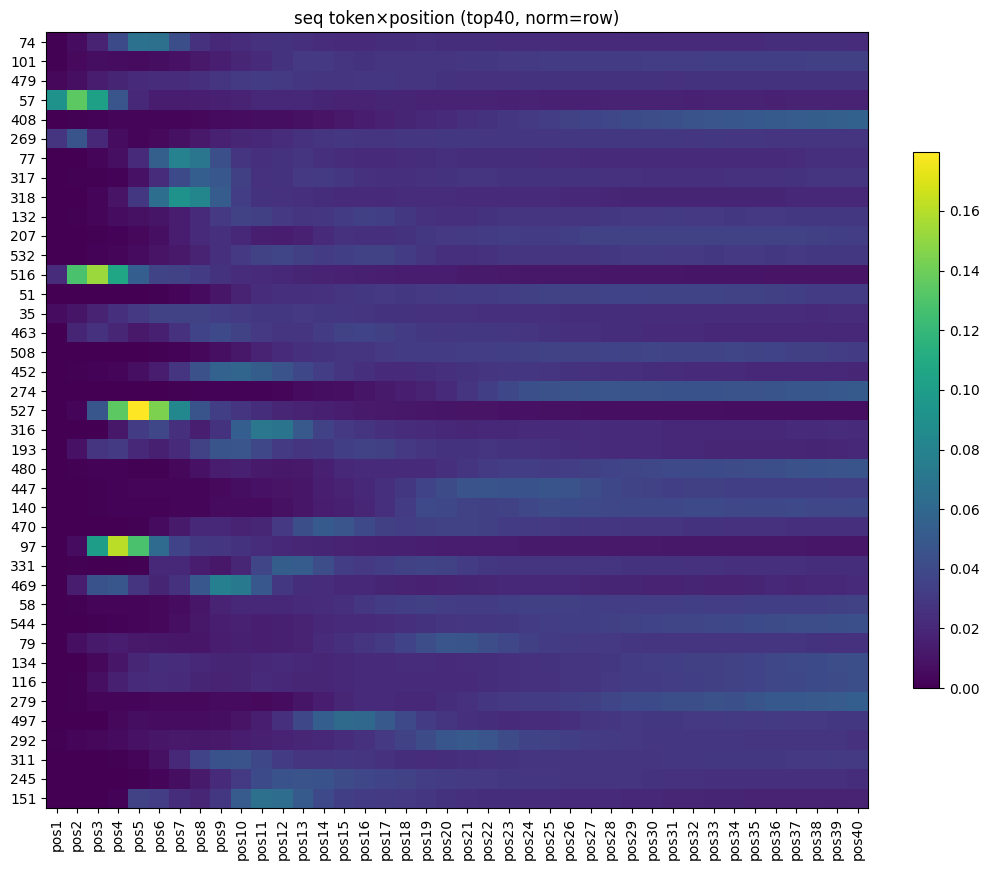

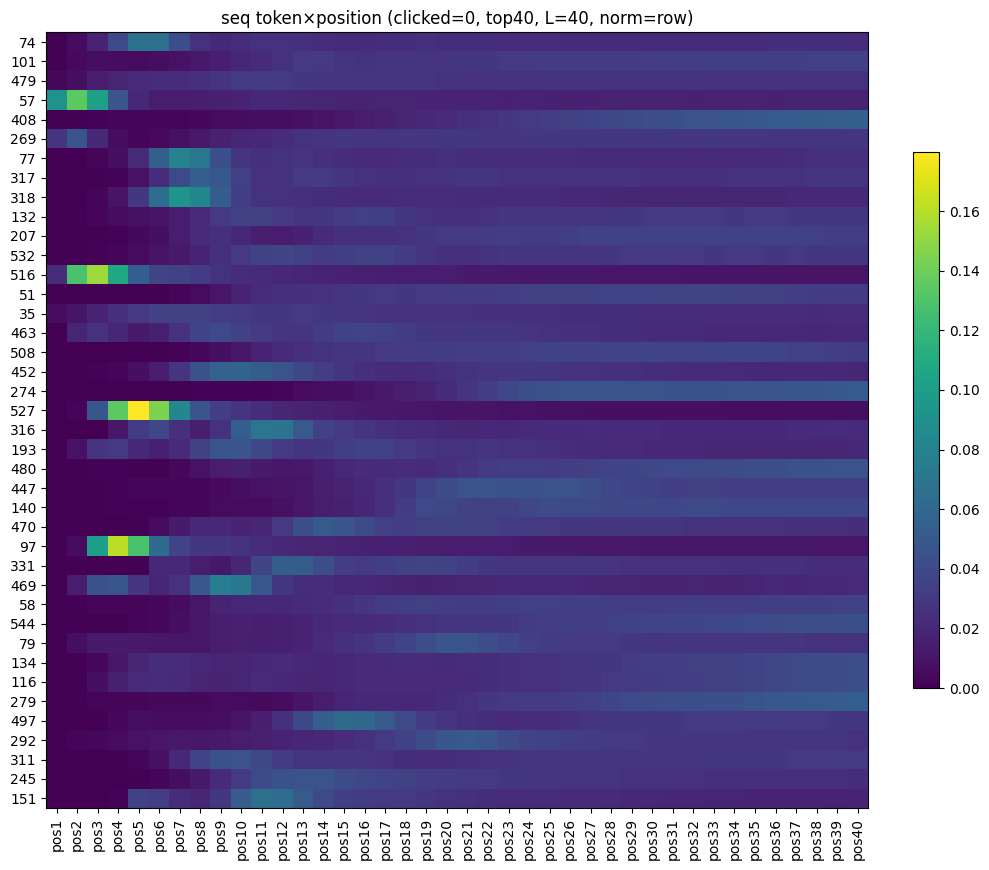

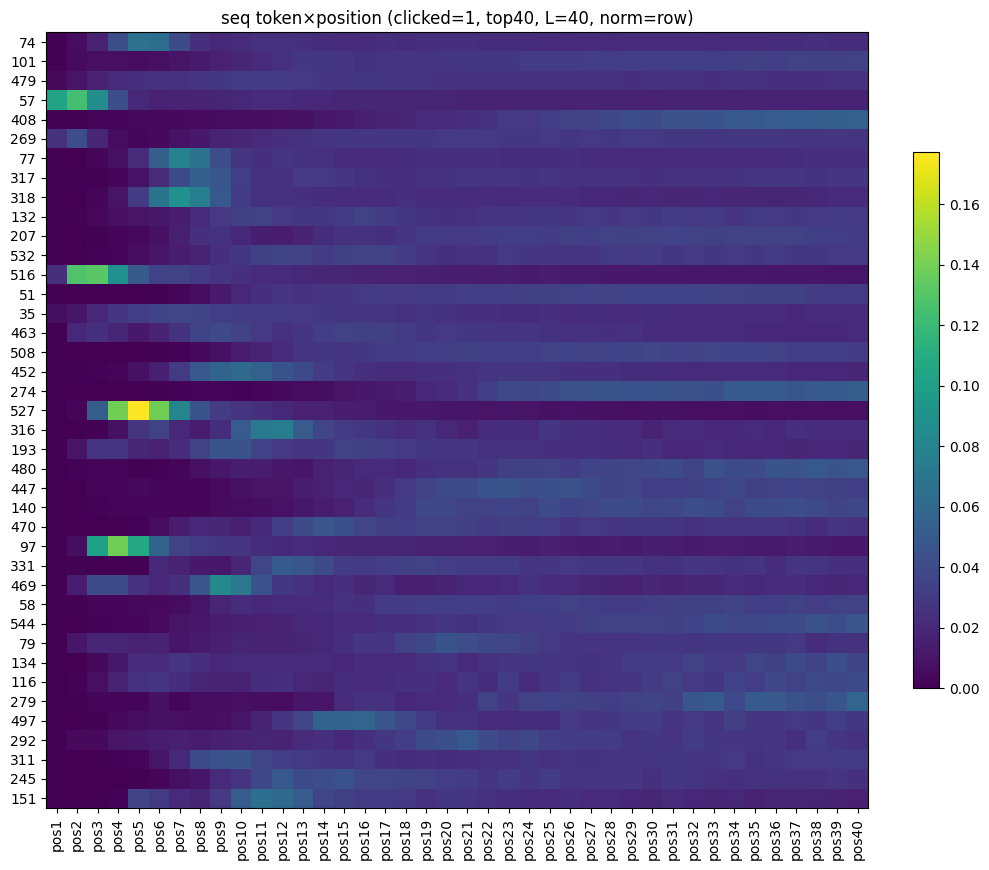

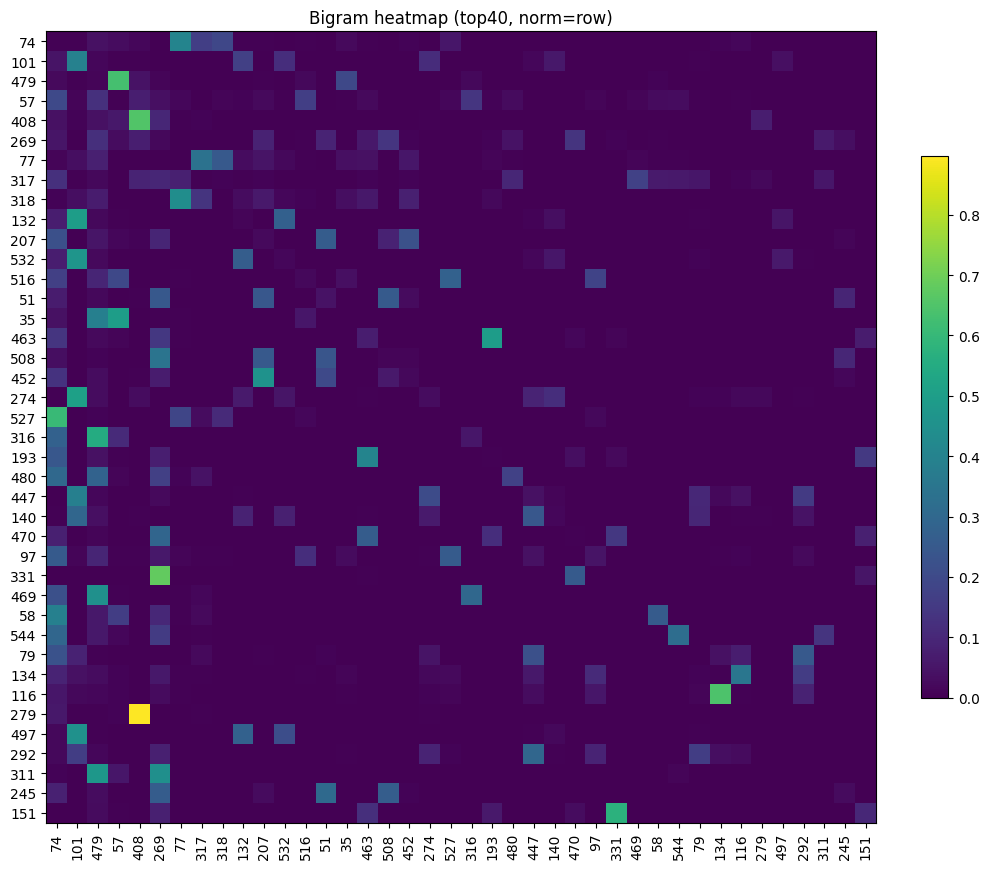

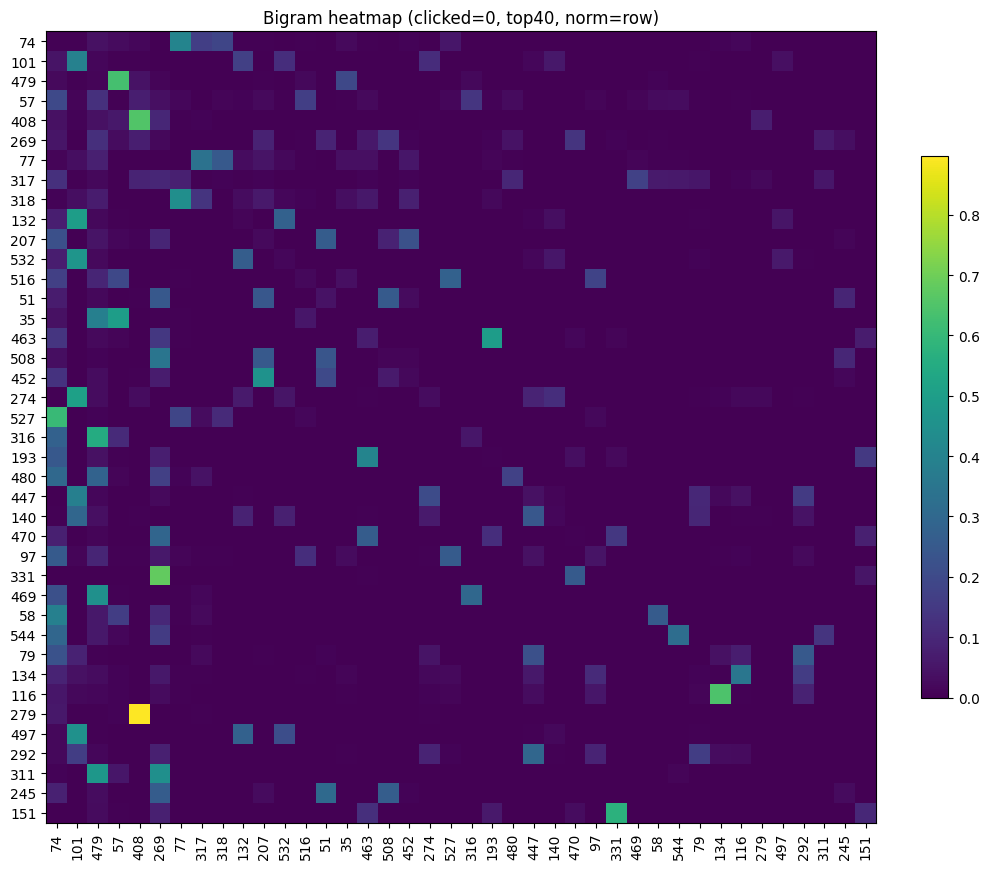

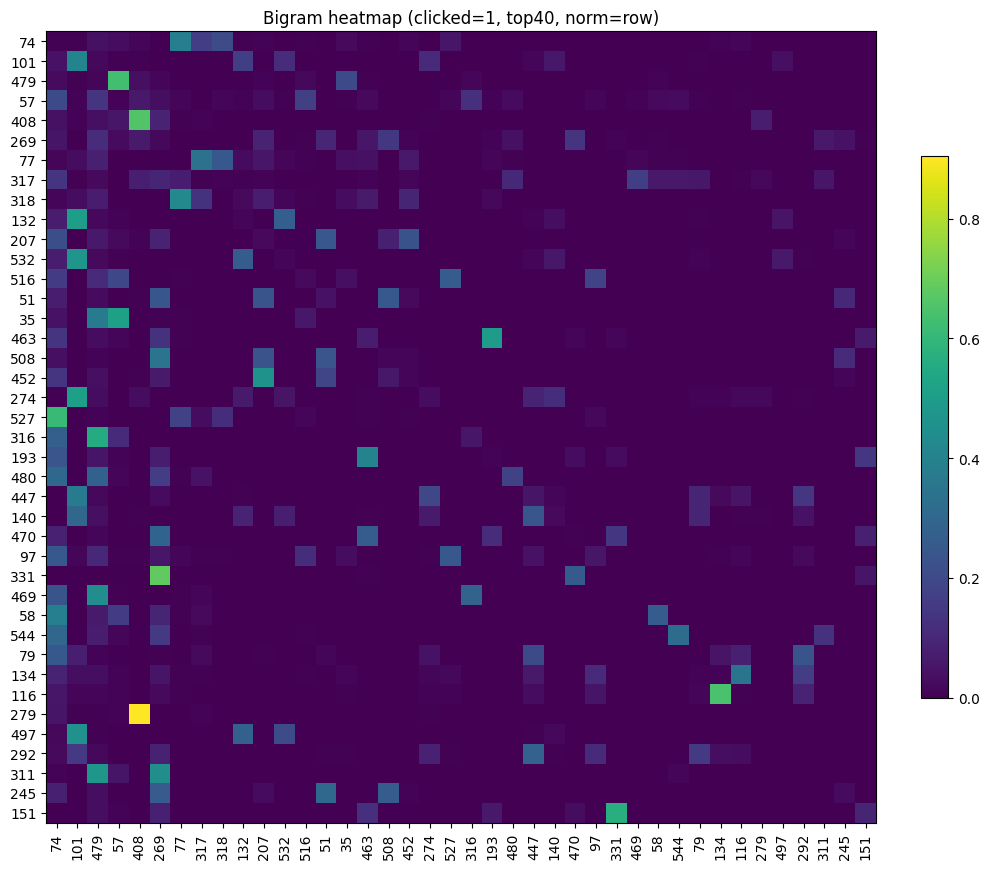

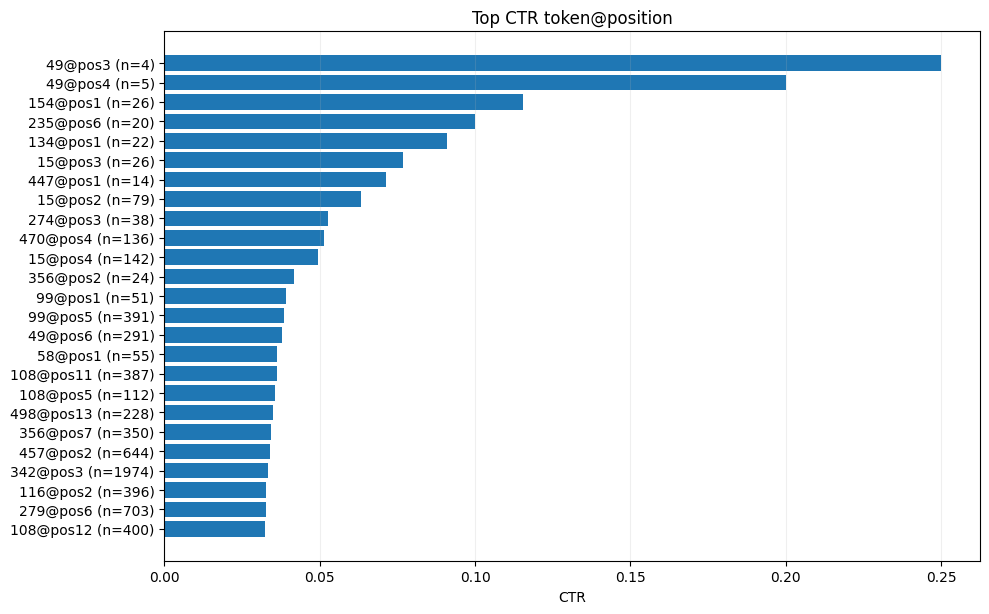

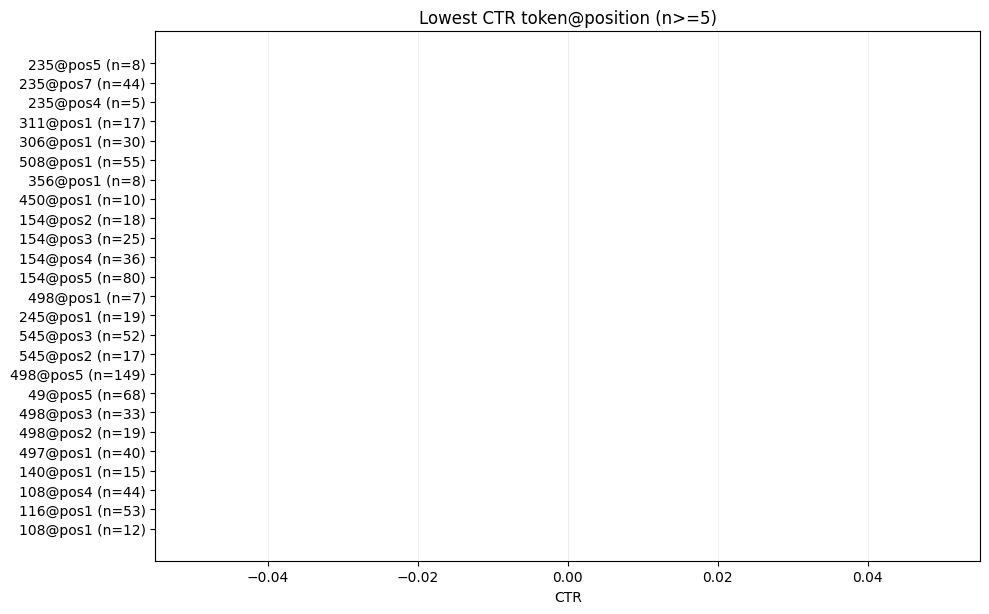

In [19]:

# ---------------------------------------
# 6-n) SEQ 실행 예시
# ---------------------------------------
seq_col = "seq"
# 1) 전체 토큰×포지션 히트맵
seqs_all = parse_seq_column(df[seq_col])
top_tokens = seq_top_tokens(seqs_all, topk=40)
mat, rows, cols = build_token_position_matrix(seqs_all, top_tokens, max_len=40, normalize="row")
plot_token_position_heatmap(mat, rows, cols, title=f"{seq_col} token×position (top40, norm=row)")

# 2) 타겟별 토큰×포지션 히트맵
plot_seq_token_position_by_target(df, seq_col=seq_col, target="clicked", topk=40, max_len=40, normalize="row")

# 3) 빅람(전이) 히트맵
plot_bigram_heatmap(df, seq_col=seq_col, target=None, topk=40, normalize="row")
plot_bigram_heatmap(df, seq_col=seq_col, target="clicked", topk=40, normalize="row")

# 4) 토큰·포지션별 CTR 표/차트
ctr_df = compute_token_position_ctr(df, seq_col=seq_col, target="clicked", max_len=40, topk=60)
plot_top_ctr_cells(ctr_df, n=25)

1. Token × Position Heatmap

클릭 그룹(clicked=1)과 비클릭 그룹(clicked=0)을 비교하면, 토큰의 등장 위치 분포가 거의 유사하다.
 → 즉, “어디서 등장했는지” 자체보다는 등장한 후 이어지는 전이가 더 중요한 차이를 만들 가능성이 있다.


2. Bigram Heatmap

다수 셀은 거의 0에 가까움 → 전이 패턴이 희소(sparse)하다는 뜻.

 그러나 몇몇 전이는 매우 강하다 (예: 116 → 특정 토큰, 527 → 특정 토큰).

3. CTR @ Token × Position

49@pos3, 49@pos4 → CTR이 0.25 수준 (매우 높음)

154@pos1, 235@pos6, 134@pos1 등도 높은 CTR

이건 “특정 토큰이 특정 위치에서 등장할 때 클릭 확률이 높아진다”는 걸 보여준다.

Lowest CTR 조합:

235@pos5, 235@pos7, 311@pos1, 306@pos1 등은 CTR이 0에 가까움

즉, 이 토큰·위치 조합은 클릭으로 이어지지 않는다.

In [21]:
# =========================================================
# Token@Position LIFT (clicked=1 vs 0)
#  - difference_lift = P(click=1 | token,pos) - P(click=1)        # 문제에서 말한 "확률 차이" 정의
#  - ratio_lift       = P(click=1 | token,pos) / P(click=1)        # 참고용 비율 리프트
#  - z-test           = 두 비율 차이 검정(선택): 조합 CTR vs 전체 CTR
# =========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from collections import Counter

# parse_seq_column(series) 가 이미 정의되어 있어야 한다.

def _overall_ctr(y):
    y = pd.Series(y).dropna().astype(int)
    return y.mean(), len(y), y.sum()

def _token_pos_table(df, seq_col="seq", target="clicked", max_len=40, topk=60):
    """Token@Position 빈도와 클릭수 집계 테이블 생성"""
    if seq_col not in df.columns or target not in df.columns:
        return pd.DataFrame(columns=["token","pos","count","clicks"])
    seqs = parse_seq_column(df[seq_col])
    if len(seqs) == 0:
        return pd.DataFrame(columns=["token","pos","count","clicks"])

    # 상위 토큰만 고려(희소 완화)
    top_tokens = set([t for t, _ in Counter(token for s in seqs for token in s).most_common(topk)])
    rows = []
    y = df[target].values
    for i, s in enumerate(seqs):
        if i >= len(y) or s is None or len(s)==0:
            continue
        yi_raw = y[i]
        if pd.isna(yi_raw):
            continue
        yi = int(yi_raw)
        for pos, tok in enumerate(s[:max_len], start=1):
            if tok in top_tokens:
                rows.append((tok, pos, yi))
    if not rows:
        return pd.DataFrame(columns=["token","pos","count","clicks"])

    tab = pd.DataFrame(rows, columns=["token","pos",target])
    agg = tab.groupby(["token","pos"])[target].agg(["count","sum"]).reset_index()
    agg = agg.rename(columns={"sum":"clicks"})
    return agg

def compute_token_pos_lift(df, seq_col="seq", target="clicked",
                           max_len=40, topk=60, min_count=10):
    """
    반환 컬럼:
      token, pos, count, clicks, ctr, base_ctr, difference_lift, ratio_lift, z_stat, p_value
    """
    base_ctr, base_n, base_clicks = _overall_ctr(df[target])
    tbl = _token_pos_table(df, seq_col=seq_col, target=target, max_len=max_len, topk=topk)
    if tbl.empty:
        return tbl

    # CTR, lift 계산
    tbl["ctr"] = tbl["clicks"] / tbl["count"].clip(lower=1)
    tbl["base_ctr"] = base_ctr
    tbl["difference_lift"] = tbl["ctr"] - base_ctr
    tbl["ratio_lift"] = tbl["ctr"] / base_ctr if base_ctr > 0 else np.nan

    # 두 비율 차이 z-test (조합 vs 전체)
    # z = (p1 - p2) / sqrt( p*(1-p)*(1/n1 + 1/n2) ), p = pooled
    n1 = tbl["count"].astype(float)
    x1 = tbl["clicks"].astype(float)
    p1 = x1 / n1
    n2 = float(base_n)
    x2 = float(base_clicks)
    p2 = base_ctr
    pooled = (x1 + x2) / (n1 + n2)
    denom = np.sqrt(np.maximum(1e-12, pooled*(1-pooled)*(1/n1 + 1/n2)))
    z = (p1 - p2) / denom
    # 양측 p-value 근사 (정규분포)
    from scipy.stats import norm
    pval = 2 * (1 - norm.cdf(np.abs(z)))
    tbl["z_stat"] = z
    tbl["p_value"] = pval

    # 신뢰성 필터
    tbl = tbl[tbl["count"] >= min_count].sort_values("difference_lift", ascending=False).reset_index(drop=True)
    return tbl

def show_lift_rankings(lift_df, top_n=30, bottom_n=30, alpha=0.05):
    """상위/하위 lift 랭킹 시각화 (차이 기반), 유의성 표시"""
    if lift_df is None or lift_df.empty:
        print("No rows to display.")
        return

    # 상위
    top = lift_df.sort_values("difference_lift", ascending=False).head(top_n).copy()
    labels = [f"{t}@pos{p} (n={c})" for t,p,c in zip(top["token"], top["pos"], top["count"])]
    sig_mask = top["p_value"] < alpha
    plt.figure(figsize=(11, max(4, 0.35*len(top))))
    plt.barh(range(len(top)), top["difference_lift"].values)
    for i, sig in enumerate(sig_mask):
        if sig:
            plt.text(top["difference_lift"].values[i], i, "  *", va="center")
    plt.gca().invert_yaxis()
    plt.yticks(range(len(top)), labels)
    plt.xlabel("Difference lift = P(click|token,pos) - P(click)")
    plt.title(f"Top +Lift Token@Position (α={alpha})")
    plt.grid(True, axis="x", alpha=0.2)
    plt.tight_layout()
    plt.show()

    # 하위
    bot = lift_df.sort_values("difference_lift", ascending=True).head(bottom_n).copy()
    labels = [f"{t}@pos{p} (n={c})" for t,p,c in zip(bot["token"], bot["pos"], bot["count"])]
    sig_mask = bot["p_value"] < alpha
    plt.figure(figsize=(11, max(4, 0.35*len(bot))))
    plt.barh(range(len(bot)), bot["difference_lift"].values)
    for i, sig in enumerate(sig_mask):
        if sig:
            plt.text(bot["difference_lift"].values[i], i, "  *", va="center")
    plt.gca().invert_yaxis()
    plt.yticks(range(len(bot)), labels)
    plt.xlabel("Difference lift = P(click|token,pos) - P(click)")
    plt.title(f"Top -Lift Token@Position (α={alpha})")
    plt.grid(True, axis="x", alpha=0.2)
    plt.tight_layout()
    plt.show()

def quick_lift_pipeline(df, seq_col="seq", target="clicked",
                        max_len=40, topk=60, min_count=10,
                        top_n=25, bottom_n=25, alpha=0.05):
    """
    한 번에: 표 생성 → 상하위 차트.
    반환: lift_df (정렬되지 않은 원본 데이터프레임)
    """
    lift_df = compute_token_pos_lift(
        df, seq_col=seq_col, target=target,
        max_len=max_len, topk=topk, min_count=min_count
    )
    show_lift_rankings(lift_df, top_n=top_n, bottom_n=bottom_n, alpha=alpha)
    return lift_df


Base CTR ≈ 0.0194


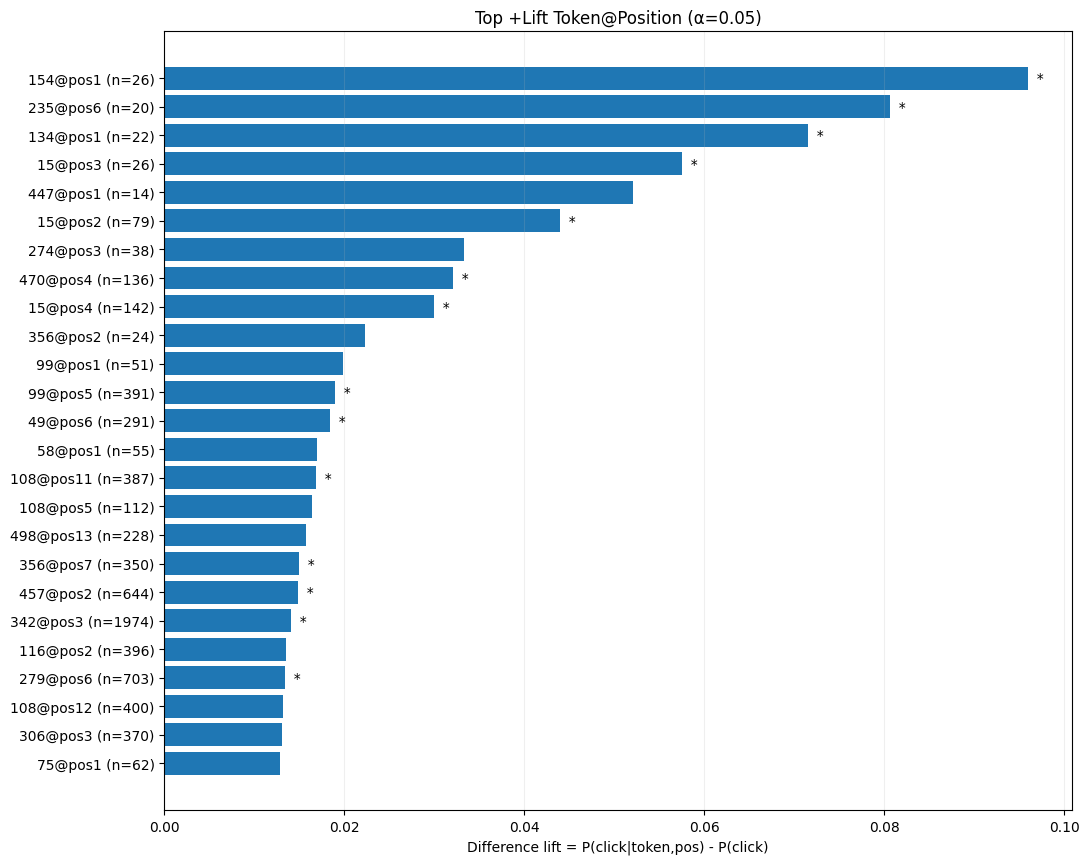

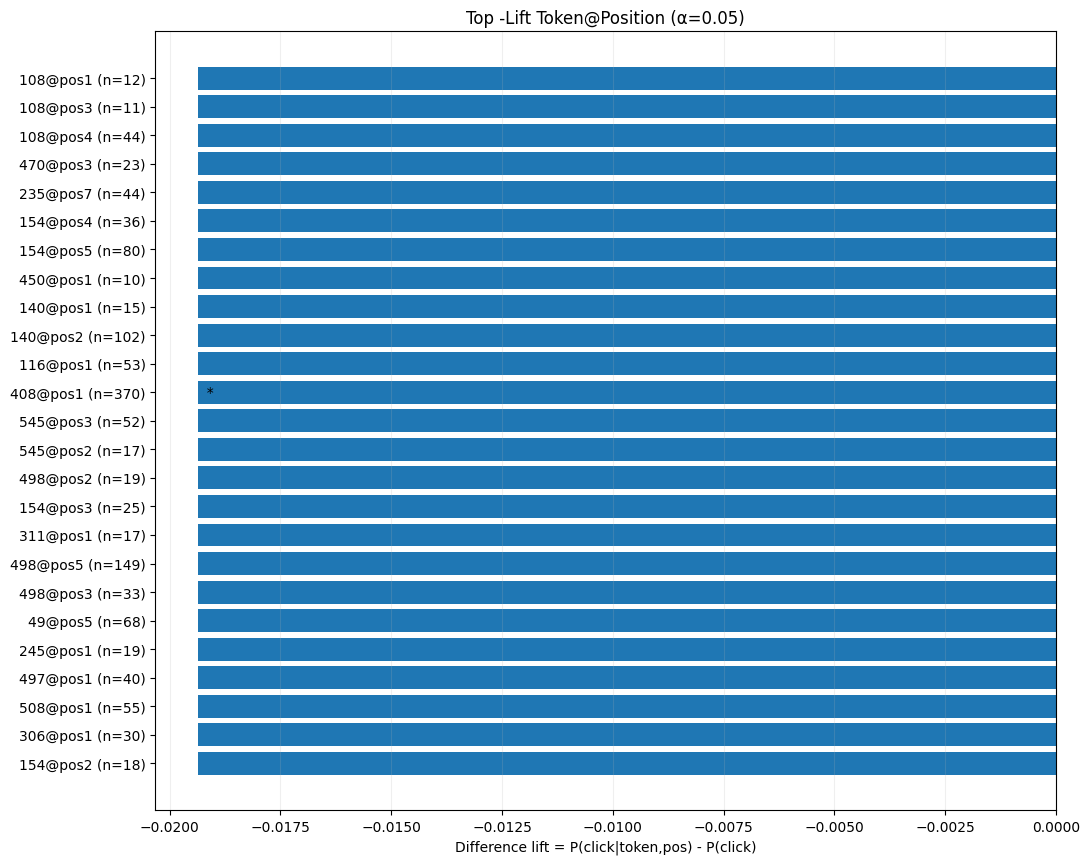

token  pos  count  clicks       ctr  base_ctr  difference_lift  ratio_lift  \
0   154    1     26       3  0.115385  0.019354         0.096031    5.961892   
1   235    6     20       2  0.100000  0.019354         0.080646    5.166973   
2   134    1     22       2  0.090909  0.019354         0.071555    4.697248   
3    15    3     26       2  0.076923  0.019354         0.057569    3.974595   
4   447    1     14       1  0.071429  0.019354         0.052075    3.690695   
5    15    2     79       5  0.063291  0.019354         0.043937    3.270236   
6   274    3     38       2  0.052632  0.019354         0.033278    2.719460   
7   470    4    136       7  0.051471  0.019354         0.032117    2.659471   
8    15    4    142       7  0.049296  0.019354         0.029942    2.547099   
9   356    2     24       1  0.041667  0.019354         0.022313    2.152905   

     z_stat   p_value  
0  3.554261  0.000379  
1  2.617909  0.008847  
2  2.436177  0.014843  
3  2.130754  0.033109  
4  1.414330  0.157265  
5  2.834608  0.004588  
6  1.489027  0.136480  
7  2.718571  0.006556  
8  2.589786  0.009604  
9  0.793454  0.427514

In [22]:
# 전체 베이스 CTR 확인용
base_ctr = df["clicked"].mean()
print(f"Base CTR ≈ {base_ctr:.4f}")

# Lift 표와 상/하위 랭킹 시각화
lift_df = quick_lift_pipeline(
    df,
    seq_col="seq", target="clicked",
    max_len=40, topk=60, min_count=10,  # 신뢰성 필터 조절
    top_n=25, bottom_n=25, alpha=0.05
)

# ratio 기반 리프트가 필요하면
lift_df_ratio_sorted = lift_df.sort_values("ratio_lift", ascending=False)
lift_df_ratio_sorted.head(10)
